Jennifer Mead

IST 718

Lab 2, week 6: S-REIT

# Introduction

Real estate investment trusts (REITs) are companies that own, operate, and finance income-generating properties including residential (like apartment buildings), industrial (like warehouses), and commerical properties (like offices). REITs pool investments from many people, similar to how mutual funds do, but they are traded like stocks. [1]

The Syracuse Real Estate Investment Trust has asked for advice on where to buy and manage properties. A successful REIT generates a steady stream of income, so we want to identify the zip codes where we expect properties to appreciate. 

Some economists focus their careers forecasting housing prices [2], so I am going to develop recommendations here, but need to acknowledge at the start that it will not be a comprehensive model. 

Given unlimited time, I would include data that reflected:

* areas with growing populations
* areas with strong economies
* a variety of residential, commercial, and industrial properties
* a variety of types of commercial real estate, in case a particular industry is impacted by economic events (for example, during a pandemic, grocery stores may do better than hair salons)
* occupancy rates of rental properties (low vacancies) and properties that tend to have long leases [3]

A "strong economy" can be defined in many different ways. Some factors include:

* population
* employment rate
* government spending
* consumer spending
* number of organic grocery stores and coffee shops
* rate of new construction

In addition to wanting to find individual zip codes where real estate values are increasing, we also want to diversify our portfolio to mitigate risk. Potential and risk go hand-in-hand, but by choosing zip codes in different geographic areas we can manage some of that risk. 

This report includes the code used to generate the models and choose the three zip codes. If you aren't interested in the details, skip to [Visualize the three zip codes](#Visualize).





# Import and prepare the data

* Load libraries
* Import file
* Remove blank rows


In [0]:
#!pip install fbprophet

In [0]:
import timeit
%matplotlib inline
import pandas as pd
import numpy as np

from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
from sklearn.tree import DecisionTreeRegressor  # machine learning tree
from sklearn.ensemble import RandomForestRegressor # ensemble method

from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [154]:
# data source: files.zillowstatic.com/research/public/Zip/SingleFamilyResidence_original.csv

df = pd.read_csv('/content/drive/My Drive/SingleFamilyResidence_original.csv', sep=',')
full_df = df
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872,1487969,1480591,1471324,1462476,1456223,1448110,1446622,1451579,1452858,1453112,1439554,1426900,1416568,1415022,1414474,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547,968807,968566,969572,972936,973010,972447,972684,975094,978629,981362,979667,976810,975419,975366,975741,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601,1578799,1585506,1587796,1591265,1596660,1598258,1596017,1595032,1592948,1590038,1576594,1562766,1552128,1545711,1540137,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200475.0,200723.0,200526.0,199337.0,198200.0,197534.0,198298.0,197986.0,197333.0,196543.0,197444.0,199129.0,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470,333247,333699,334667,335386,335194,335478,335777,336150,336558,336390,336776,336806,336869,336217,335679,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,546663.0,546231.0,545451.0,545391.0,543066.0,543084.0,542380.0,545254.0,548142.0,552660.0,557791.0,562238.0,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,1208903.0,1213170,1209707,1207080,1206948,1208617,1208706,1208528,1209725,1211606,1214779,1216093,1212725,1208171,1206835,1207121,1208395,1207765,1208853,1208481,1206304,1204013,1201182,1198879,1198277,1199900,1200980


In [6]:
df.describe()

,RegionID,SizeRank,RegionName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
count,30464.000000,30464.000000,30464.000000,1.322400e+04,1.347200e+04,1.351000e+04,1.353200e+04,1.361700e+04,1.365200e+04,1.367500e+04,1.371000e+04,1.373000e+04,1.375000e+04,1.377000e+04,1.380100e+04,1.391300e+04,1.396100e+04,1.401900e+04,1.407000e+04,1.410000e+04,1.412000e+04,1.413900e+04,1.418500e+04,1.423400e+04,1.427600e+04,1.432600e+04,1.434500e+04,1.438500e+04,1.441400e+04,1.450700e+04,1.467100e+04,1.477200e+04,1.487300e+04,1.492500e+04,1.503800e+04,1.513300e+04,1.518800e+04,1.522200e+04,1.523500e+04,1.538900e+04,...,2.999500e+04,3.007200e+04,3.009800e+04,3.013400e+04,3.014800e+04,3.019600e+04,3.020600e+04,3.022500e+04,3.024800e+04,3.027700e+04,3.030700e+04,3.032500e+04,3.034700e+04,3.042900e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04,3.046400e+04
mean,80411.444032,15971.949875,48773.301110,1.287668e+05,1.284274e+05,1.283393e+05,1.283755e+05,1.284372e+05,1.284450e+05,1.287817e+05,1.289064e+05,1.290751e+05,1.292990e+05,1.295772e+05,1.298575e+05,1.300986e+05,1.304241e+05,1.308135e+05,1.312118e+05,1.315644e+05,1.319595e+05,1.323749e+05,1.327408e+05,1.330861e+05,1.334340e+05,1.339713e+05,1.345007e+05,1.350935e+05,1.356018e+05,1.357957e+05,1.358623e+05,1.361875e+05,1.365630e+05,1.369477e+05,1.372981e+05,1.376924e+05,1.382902e+05,1.388599e+05,1.394366e+05,1.397024e+05,...,2.077325e+05,2.084516e+05,2.091881e+05,2.099169e+05,2.108083e+05,2.116201e+05,2.126070e+05,2.134940e+05,2.143634e+05,2.153145e+05,2.163177e+05,2.174370e+05,2.185168e+05,2.194831e+05,2.205078e+05,2.216575e+05,2.227131e+05,2.236364e+05,2.245148e+05,2.253903e+05,2.261937e+05,2.268839e+05,2.275366e+05,2.282122e+05,2.288102e+05,2.293072e+05,2.297105e+05,2.301173e+05,2.305879e+05,2.310848e+05,2.316270e+05,2.322013e+05,2.328094e+05,2.334704e+05,2.341255e+05,2.347233e+05,2.353932e+05,2.361603e+05,2.370185e+05,2.378982e+05
std,25500.467961,9602.814124,27437.793823,8.932606e+04,8.923079e+04,8.908503e+04,8.891757e+04,8.878505e+04,8.866373e+04,9.173599e+04,9.169042e+04,9.180962e+04,9.205492e+04,9.233025e+04,9.263102e+04,9.279425e+04,9.319905e+04,9.355385e+04,9.382128e+04,9.416263e+04,9.456203e+04,9.505737e+04,9.547992e+04,9.582391e+04,9.614764e+04,9.656395e+04,9.709946e+04,9.759362e+04,9.814967e+04,9.871450e+04,9.928054e+04,1.000212e+05,1.008114e+05,1.016547e+05,1.024022e+05,1.033956e+05,1.043507e+05,1.053646e+05,1.062769e+05,1.082983e+05,...,2.536488e+05,2.542299e+05,2.548135e+05,2.552662e+05,2.562648e+05,2.575337e+05,2.589384e+05,2.598181e+05,2.607641e+05,2.621635e+05,2.637641e+05,2.657879e+05,2.674231e+05,2.689980e+05,2.706107e+05,2.724094e+05,2.734608e+05,2.740333e+05,2.745186e+05,2.753777e+05,2.762055e+05,2.766995e+05,2.770444e+05,2.771573e+05,2.768020e+05,2.758761e+05,2.748866e+05,2.742668e+05,2.741909e+05,2.743269e+05,2.744219e+05,2.745258e+05,2.745434e+05,2.747149e+05,2.748821e+05,2.751632e+05,2.759450e+05,2.772066e+05,2.787410e+05,2.801460e+05
min,58001.000000,0.000000,501.0

In [0]:
#pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

In [0]:
# there are some blanks in the sample above. How common is that in this dataset?
blanks = df.isna().sum()
#print(blanks.head(15))
#print(blanks.tail(15))
# reference: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe


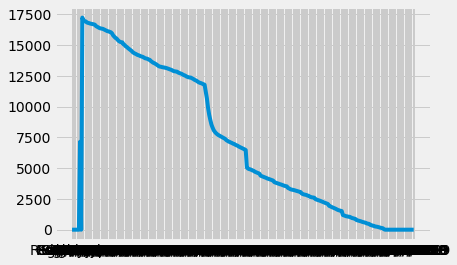

In [9]:
# There are 300 columns, but some of those columns have as many as 17,000 blanks. We have more data for the more recent dates. 

plt.plot(blanks)

# Part 1: Explore the data: key metro areas in Arkansas

* Summarize using descriptive statistics
* Visualize the data
* Make time series plots for Hot Springs, Little Rock, Fayetteville, and Searcy (Arkansas), showing all values from 1997 to present, average at the metro level
* Forecast the housing prices for eight quarters for Fayetteville

These may not be chosen by the US-wide model, but they demonstrate techniques we will use for the zip codes we eventually choose.

In [10]:
# create a subset for the 4 key metro areas in Arkansas between 1997 and 2020
# reference: https://stackoverflow.com/questions/26347412/drop-multiple-columns-in-pandas

Ark_metro = df.drop(df.columns[[0, 3, 4, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]], axis=1)
Ark_metro.head()

,SizeRank,RegionName,State,City,Metro,CountyName,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,8/31/1999,9/30/1999,10/31/1999,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
0,0,10025,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872,1487969,1480591,1471324,1462476,1456223,1448110,1446622,1451579,1452858,1453112,1439554,1426900,1416568,1415022,1414474,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268
1,1,60657,IL,Chicago,Chicago-Naperville-Elgin,Cook County,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,408057.0,416827.0,425087.0,432120.0,436962.0,441150.0,444482.0,447753.0,450885.0,455497.0,461395.0,467344.0,472584.0,477269.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547,968807,968566,969572,972936,973010,972447,972684,975094,978629,981362,979667,976810,975419,975366,975741,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642
2,2,10023,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601,1578799,1585506,1587796,1591265,1596660,1598258,1596017,1595032,1592948,1590038,1576594,1562766,1552128,1545711,1540137,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994
3,3,77494,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,204133.0,204600.0,206225.0,207084.0,207630.0,208343.0,209594.0,210422.0,211729.0,212988.0,214708.0,215968.0,216236.0,216355.0,...,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,333159.0,333470,333247,333699,334667,335386,335194,335478,335777,336150,336558,336390,336776,336806,336869,336217,335679,335536,335878,335940,336092,336119,336083,336154,335860,336037,336483
4,4,60614,IL,Chicago,Chicago-Naperville-Elgin,Cook County,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,630536.0,643350.0,654584.0,665638.0,674824.0,681464.0,686767.0,690649.0,696743.0,700375.0,707488.0,714017.0,722142.0,727557.0,734938.0,...,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0,1208903.0,1213170,1209707,1207080,1206948,1208617,1208706,1208528,1209725,1211606,1214779,1216093,1212725,1208171,1206835,1207121,1208395,1207765,1208853,1208481,1206304,1204013,1201182,1198879,1198277,1199900,1200980


In [11]:
# reference: https://www.interviewqs.com/ddi_code_snippets/rows_cols_python
# sample: df.loc[df['favorite_color'] == 'yellow']
Ark_metro = Ark_metro[Ark_metro['State'] == 'AR']
Ark_metro.head()

,SizeRank,RegionName,State,City,Metro,CountyName,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,8/31/1999,9/30/1999,10/31/1999,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
331,332,71913,AR,Hot Springs,Hot Springs,Garland County,90258.0,91196.0,91644.0,91640.0,90742.0,90304.0,90422.0,90982.0,91873.0,92190.0,92473.0,92837.0,93669.0,94109.0,94516.0,94808.0,95420.0,95850.0,96356.0,96397.0,96269.0,96486.0,96716.0,96730.0,96249.0,95697.0,95418.0,95151.0,94976.0,94962.0,95166.0,95589.0,96014.0,96268.0,...,143742.0,144141.0,144996.0,145550.0,145912.0,146185.0,146335.0,146544.0,146539.0,146800.0,147261.0,148059.0,149129.0,149326.0,149070,149441,150307,151218,151702,152519,153299,153764,153940,154465,155178,156302,157060,157160,157093,157351,158061,158528,159213,160118,161110,161806,162347,163134,164485,166238
663,664,72034,AR,Conway,Little Rock-North Little Rock-Conway,Faulkner County,103502.0,104205.0,104874.0,105728.0,106261.0,106638.0,106857.0,107009.0,107256.0,107601.0,108106.0,108645.0,109683.0,110572.0,111355.0,111680.0,112094.0,112554.0,112843.0,113132.0,113391.0,113755.0,114076.0,114305.0,113789.0,113170.0,112680.0,112700.0,112916.0,113050.0,113202.0,113254.0,113352.0,113447.0,...,168956.0,169308.0,169582.0,169950.0,170157.0,170426.0,170660.0,171039.0,171386.0,171589.0,171833.0,172140.0,172667.0,173115.0,173578,174113,174864,175597,176041,176604,177103,177811,178324,178867,179303,179857,180481,181027,181591,182011,182649,183101,183628,184046,184578,185073,185563,186034,186445,186853
868,870,72701,AR,Fayetteville,Fayetteville-Springdale-Rogers,Washington County,96387.0,96430.0,96565.0,97165.0,97724.0,98126.0,98531.0,98966.0,99434.0,99900.0,100352.0,100830.0,102263.0,103586.0,104887.0,104902.0,105163.0,105428.0,105874.0,106111.0,106446.0,106788.0,107000.0,107087.0,106633.0,106325.0,105909.0,106265.0,106443.0,106621.0,106532.0,106572.0,106785.0,106979.0,...,192207.0,192476.0,193003.0,193737.0,194088.0,193982.0,194070.0,195607.0,197708.0,199560.0,200907.0,202720.0,204034.0,205663.0,207292,208761,210155,211138,212423,213283,213988,214719,215876,217231,218568,219479,220062,220863,222232,223712,224812,225642,226377,227098,227647,227829,228159,228725,229374,229775
913,916,72764,AR,Springdale,Fayetteville-Springdale-Rogers,Washington County,93065.0,93327.0,93611.0,94126.0,94488.0,94848.0,95266.0,95645.0,96001.0,96308.0,96706.0,97078.0,97925.0,98536.0,99152.0,99141.0,99429.0,99785.0,99758.0,100096.0,100323.0,100959.0,101027.0,101108.0,100602.0,100238.0,99828.0,100057.0,100071.0,100072.0,100113.0,100063.0,100041.0,99985.0,...,144069.0,144677.0,145378.0,146074.0,146450.0,146537.0,146657.0,147808.0,149395.0,150897.0,151933.0,153146.0,154212.0,155569.0,157159,158398,159571,160392,161633,162404,162893,163261,164059,165031,165919,166533,166951,167979,169392,170889,171834,172676,173534,174342,174884,175082,175275,175506,175605,175228
1230,1236,72401,AR,Jonesboro,Jonesboro,Craighead County,73277.0,73477.0,73651.0,73985.0,74238.0,74459.0,74674.0,74899.0,75173.0,75369.0,75629.0,75924.0,76562.0,77036.0,77451.0,77498.0,77663.0,77958.0,78433.0,78958.0,79364.0,79659.0,79799.0,79921.0,79773.0,79728.0,79806.0,80128.0,80509.0,80796.0,81019.0,81096.0,81159.0,81367.0,...,118059.0,118334.0,118492.0,118836.0,119342.0,119950.0,120283.0,120382.0,120360.0,120619.0,121075.0,121572.0,121799.0,122183.0,122649,123227,123689,124006,124305,1

In [12]:
# reference: https://www.interviewqs.com/ddi_code_snippets/rows_cols_python
# sample: df.loc[df['favorite_color'].isin(array)]
metro_array = ['Hot Springs', 'Fayetteville-Springdale-Rogers', 'Little Rock-North Little Rock-Conway', 'Searcy']
Ark_metro = Ark_metro.loc[Ark_metro['Metro'].isin(metro_array)]
Ark_metro.head(3)


,SizeRank,RegionName,State,City,Metro,CountyName,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,8/31/1999,9/30/1999,10/31/1999,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
331,332,71913,AR,Hot Springs,Hot Springs,Garland County,90258.0,91196.0,91644.0,91640.0,90742.0,90304.0,90422.0,90982.0,91873.0,92190.0,92473.0,92837.0,93669.0,94109.0,94516.0,94808.0,95420.0,95850.0,96356.0,96397.0,96269.0,96486.0,96716.0,96730.0,96249.0,95697.0,95418.0,95151.0,94976.0,94962.0,95166.0,95589.0,96014.0,96268.0,...,143742.0,144141.0,144996.0,145550.0,145912.0,146185.0,146335.0,146544.0,146539.0,146800.0,147261.0,148059.0,149129.0,149326.0,149070,149441,150307,151218,151702,152519,153299,153764,153940,154465,155178,156302,157060,157160,157093,157351,158061,158528,159213,160118,161110,161806,162347,163134,164485,166238
663,664,72034,AR,Conway,Little Rock-North Little Rock-Conway,Faulkner County,103502.0,104205.0,104874.0,105728.0,106261.0,106638.0,106857.0,107009.0,107256.0,107601.0,108106.0,108645.0,109683.0,110572.0,111355.0,111680.0,112094.0,112554.0,112843.0,113132.0,113391.0,113755.0,114076.0,114305.0,113789.0,113170.0,112680.0,112700.0,112916.0,113050.0,113202.0,113254.0,113352.0,113447.0,...,168956.0,169308.0,169582.0,169950.0,170157.0,170426.0,170660.0,171039.0,171386.0,171589.0,171833.0,172140.0,172667.0,173115.0,173578,174113,174864,175597,176041,176604,177103,177811,178324,178867,179303,179857,180481,181027,181591,182011,182649,183101,183628,184046,184578,185073,185563,186034,186445,186853
868,870,72701,AR,Fayetteville,Fayetteville-Springdale-Rogers,Washington County,96387.0,96430.0,96565.0,97165.0,97724.0,98126.0,98531.0,98966.0,99434.0,99900.0,100352.0,100830.0,102263.0,103586.0,104887.0,104902.0,105163.0,105428.0,105874.0,106111.0,106446.0,106788.0,107000.0,107087.0,106633.0,106325.0,105909.0,106265.0,106443.0,106621.0,106532.0,106572.0,106785.0,106979.0,...,192207.0,192476.0,193003.0,193737.0,194088.0,193982.0,194070.0,195607.0,197708.0,199560.0,200907.0,202720.0,204034.0,205663.0,207292,208761,210155,211138,212423,213283,213988,214719,215876,217231,218568,219479,220062,220863,222232,223712,224812,225642,226377,227098,227647,227829,228159,228725,229374,229775


In [13]:
# reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.groupby.GroupBy.mean.html
# sample: df.groupby('A').mean()

Ark_metro4 = round(Ark_metro.groupby('Metro').mean(), 0)
Ark_metro4 = Ark_metro4.drop(columns=['SizeRank', 'RegionName'])
Ark_metro4.head()

,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,8/31/1999,9/30/1999,10/31/1999,11/30/1999,12/31/1999,1/31/2000,2/29/2000,3/31/2000,4/30/2000,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
Metro,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Fayetteville-Springdale-Rogers,96580.0,96850.0,97152.0,97600.0,97908.0,97910.0,97736.0,97587.0,97667.0,97953.0,98429.0,98816.0,99259.0,99524.0,99797.0,99841.0,99943.0,100233.0,100647.0,101014.0,99523.0,97312.0,97150.0,97068.0,96999.0,97211.0,97275.0,97432.0,97712.0,98100.0,98601.0,98860.0,99010.0,99038.0,99183.0,99357.0,99481.0,99681.0,100002.0,100415.0,...,151732.0,152055.0,152323.0,152491.0,152841.0,153081.0,153597.0,153228.0,154661.0,155944.0,156708.0,157389.0,158008.0,159338.0,160946.0,162358.0,163661.0,164528.0,165112.0,165049.0,164766.0,164768.0,165245.0,165846.0,166664.0,166932.0,167256.0,167882.0,168821.0,169895.0,170895.0,172141.0,173434.0,174525.0,175459.0,176282.0,176945.0,177803.0,178468.0,178979.0
Hot Springs,77183.0,77657.0,77873.0,77722.0,77370.0,77364.0,77931.0,78521.0,79080.0,78899.0,78778.0,79053.0,79791.0,80121.0,80180.0,80155.0,80002.0,80217.0,80237.0,80327.0,80087.0,80207.0,80258.0,80203.0,79771.0,79431.0,79310.0,79590.0,79948.0,80191.0,80357.0,80687.0,81088.0,81706.0,82448.0,83207.0,84120.0,84658.0,85299.0,85548.0,...,117817.0,118104.0,118364.0,118410.0,118913.0,118988.0,118800.0,119029.0,119529.0,119999.0,120178.0,120199.0,120820.0,121296.0,121742.0,122392.0,122953.0,123727.0,124753.0,125939.0,126744.0,127043.0,127097.0,127619.0,127876.0,128654.0,129007.0,129288.0,129399.0,129874.0,130195.0,130270.0,130643.0,131521.0,132674.0,133556.0,134452.0,135230.0,136497.0,137893.0
Little Rock-North Little Rock-Conway,87379.0,87693.0,87890.0,88179.0,88397.0,88618.0,88776.0,89037.0,89458.0,89739.0,91140.0,91449.0,91921.0,92205.0,92475.0,92115.0,92427.0,93009.0,93595.0,94150.0,94488.0,94874.0,95093.0,95279.0,95278.0,95342.0,95430.0,95058.0,95243.0,95370.0,95439.0,95439.0,95422.0,95496.0,95666.0,96022.0,96363.0,96763.0,97140.0,97670.0,...,129025.0,129367.0,129608.0,130099.0,130564.0,131110.0,131554.0,132159.0,132611.0,133038.0,133480.0,133979.0,133022.0,133337.0,133632.0,133835.0,134055.0,134330.0,134641.0,135158.0,135407.0,135630.0,135638.0,135939.0,136367.0,136995.0,137572.0,137741.0,137819.0,137729.0,137957.0,137968.0,138232.0,138563.0,139093.0,139402.0,139585.0,139714.0,139935.0,140491.0
Searcy,57561.0,57888.0,58211.0,58466.0,58640.0,58766.0,58922.0,59028.0,59160.0,59267.0,59445.0,59605.0,59678.0,59691.0,59626.0,59688.0,59859.0,60209.0,60712.0,61120.0,61623.0,62013.0,62363.0,62552.0,62763.0,63087.0,63384.0,63491.0,63522.0,63562.0,63467.0,63417.0,63261.0,63147.0,62986.0,63022.0,63022.0,63085.0,63133.0,63344.0,...,79038.0,79312.0,79585.0,79776.0,80043.0,80240.0,80500.0,80752.0,81225.0,81643.0,81960.0,82197.0,82664.0,83102.0,83378.0,83543.0,83718.0,84004.0,84126.0,84260.0,84649.0,84984.0,85361.0,85893.0,86799.0,87424.0,87565.0,87443.0,87586.0,87683.0,87910.0,88080.0,87891.0,87740.0,87567.0,87298.0,86612.0,86112.0,86011.0,86116.0


In [0]:
# transpose time series matrices
# df = df.T
# reference: https://thispointer.com/select-rows-columns-by-name-or-index-in-dataframe-using-loc-iloc-python-pandas/
# rowData = dfObj.loc[ 'b' , : ]
# df = df.set_index('ZipCode')
## df.index = pd.to_datetime(df.index)

#Searcy_ts = pd.DataFrame(Ark_metro4.loc['Searcy', :])
#Searcy_ts.reset_index(inplace=True)
#Searcy_ts = Searcy_ts.rename(index=str, columns={"Searcy": "HouseValue", "index": "Date"})
#Searcy_ts.Date = pd.to_datetime(Searcy_ts.Date)
#Searcy_ts.head()

In [0]:
def make_ts(area, name):
  area_ts = pd.DataFrame(area)
  area_ts.reset_index(inplace=True)
  area_ts = area_ts.rename(index=str, columns={name: "HouseValue", "index": "Date"})
  area_ts.Date = pd.to_datetime(area_ts.Date)
  print(name, ":")
  print(area_ts.shape)
  print(area_ts.head())
  return area_ts



In [16]:
Searcy = Ark_metro4.loc['Searcy', :]

Searcy_2 = make_ts(Searcy, 'Searcy')

Searcy :
(279, 2)
        Date  HouseValue
0 1997-01-31     57561.0
1 1997-02-28     57888.0
2 1997-03-31     58211.0
3 1997-04-30     58466.0
4 1997-05-31     58640.0


In [0]:
#ax = Searcy_2.set_index('Date').plot(figsize=(12, 8))
#ax.set_ylabel('Price')
#ax.set_xlabel('Date')
#ax.set_title('Searcy Metro Area Housing Prices')

#plt.show()

## Visualize housing price trends in the four key Arkansas metro areas

In [0]:
def draw_housingprice (area, name):
  ax = area.set_index('Date').plot(figsize=(12, 8))
  ax.set_ylabel('Price')
  ax.set_xlabel('Date')
  ax.set_title(name)
  plt.show()

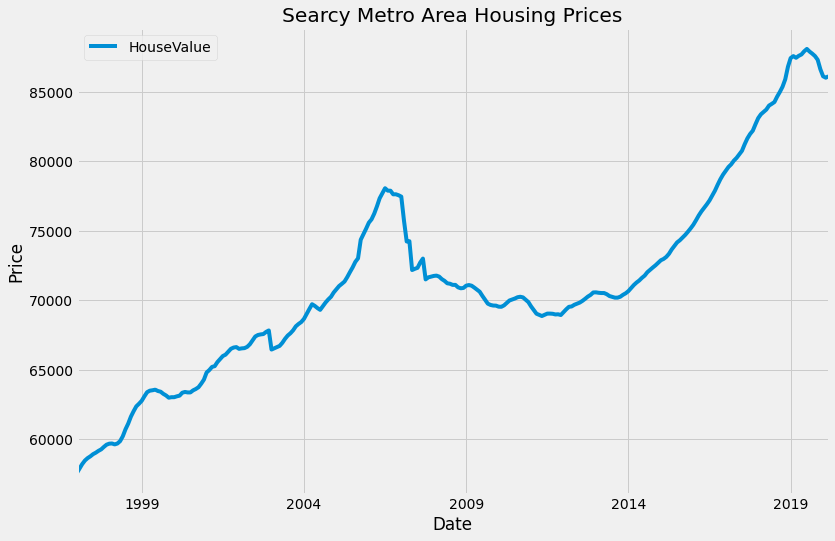

In [19]:
Searcy_graph = draw_housingprice(Searcy_2, 'Searcy Metro Area Housing Prices')
Searcy_graph

In [20]:
#metro_array = ['Hot Springs', 'Fayetteville-Springdale-Rogers', 'Little Rock-North Little Rock-Conway', 'Searcy']
HotSprings = Ark_metro4.loc['Hot Springs', :]
HotSprings_2 = make_ts(HotSprings, 'Hot Springs')


Hot Springs :
(279, 2)
        Date  HouseValue
0 1997-01-31     77183.0
1 1997-02-28     77657.0
2 1997-03-31     77873.0
3 1997-04-30     77722.0
4 1997-05-31     77370.0


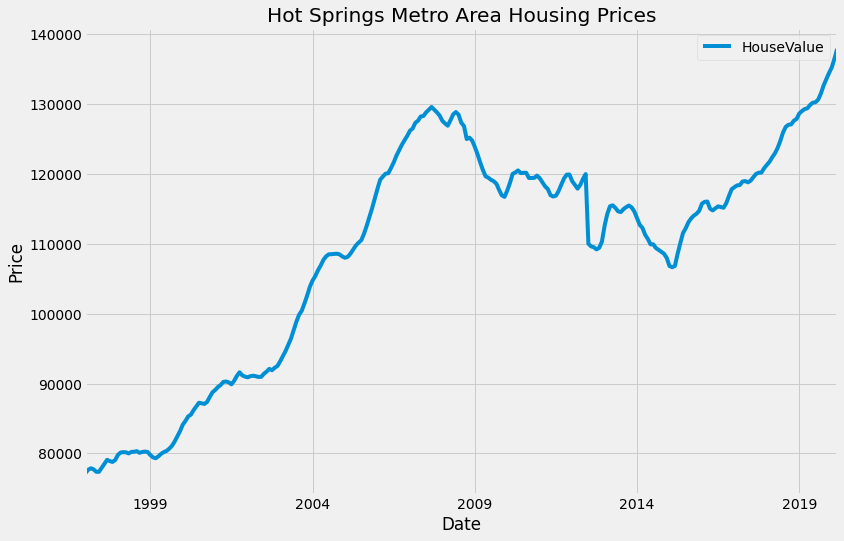

In [21]:
HotSprings_graph = draw_housingprice(HotSprings_2, 'Hot Springs Metro Area Housing Prices')
HotSprings_graph

In [22]:
Fayetteville = Ark_metro4.loc['Fayetteville-Springdale-Rogers', :]
Fayetteville_2 = make_ts(Fayetteville, 'Fayetteville-Springdale-Rogers')

Fayetteville-Springdale-Rogers :
(279, 2)
        Date  HouseValue
0 1997-01-31     96580.0
1 1997-02-28     96850.0
2 1997-03-31     97152.0
3 1997-04-30     97600.0
4 1997-05-31     97908.0


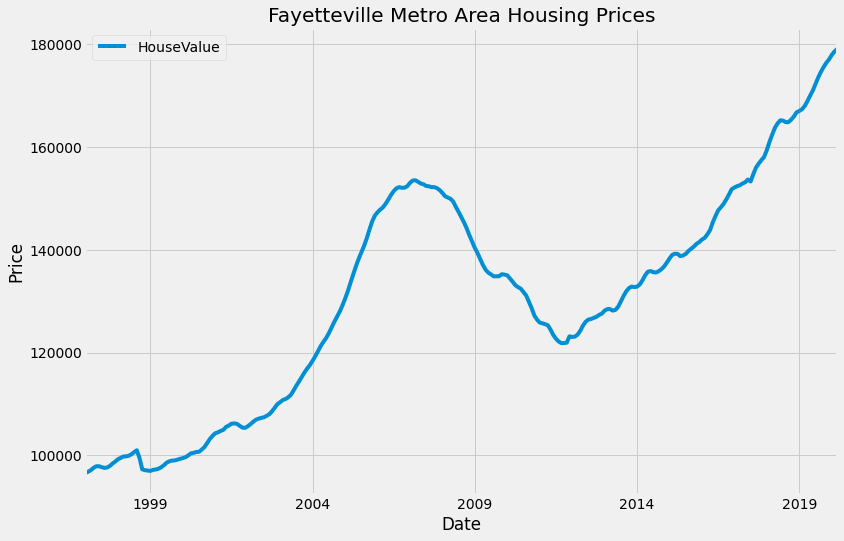

In [23]:
Fayetteville_graph = draw_housingprice(Fayetteville_2, 'Fayetteville Metro Area Housing Prices')
Fayetteville_graph

In [24]:
LittleRock = Ark_metro4.loc['Little Rock-North Little Rock-Conway', :]
LittleRock_2 = make_ts(LittleRock, 'Little Rock-North Little Rock-Conway')

Little Rock-North Little Rock-Conway :
(279, 2)
        Date  HouseValue
0 1997-01-31     87379.0
1 1997-02-28     87693.0
2 1997-03-31     87890.0
3 1997-04-30     88179.0
4 1997-05-31     88397.0


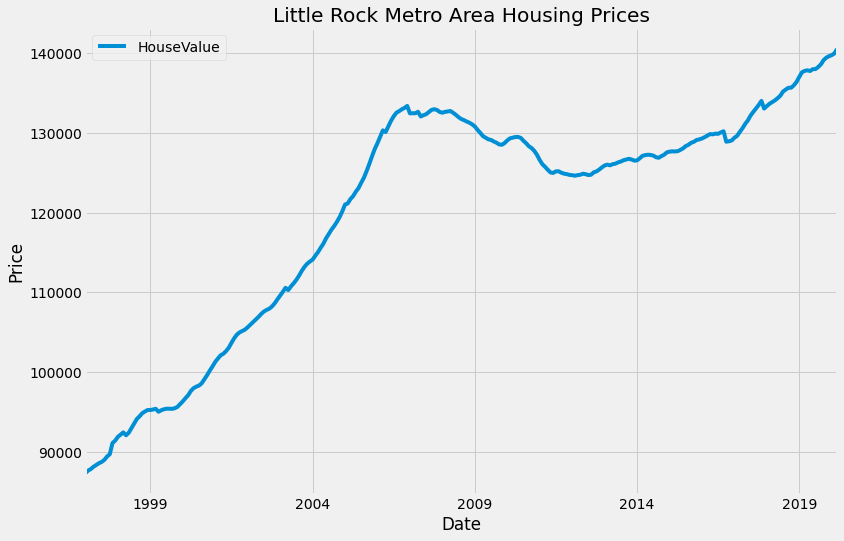

In [25]:
LittleRock_graph = draw_housingprice(LittleRock_2, 'Little Rock Metro Area Housing Prices')
LittleRock_graph

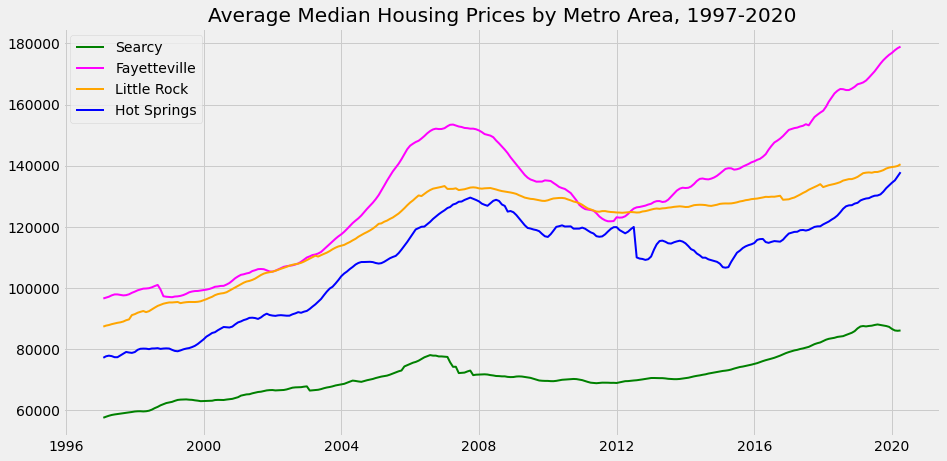

In [26]:
# What do these four metro areas look like compared to each other?
plt.figure(figsize=(14,7))
plt.title("Average Median Housing Prices by Metro Area, 1997-2020")
plt.plot( 'Date', 'HouseValue', data=Searcy_2, marker='',  color='green', linewidth=2,  label="Searcy")
plt.plot( 'Date', 'HouseValue', data=Fayetteville_2, marker='', color='magenta', linewidth=2,  label="Fayetteville")
plt.plot( 'Date', 'HouseValue', data=LittleRock_2, marker='', color='orange', linewidth=2,  label="Little Rock")
plt.plot( 'Date', 'HouseValue', data=HotSprings_2, marker='', color='blue', linewidth=2,  label="Hot Springs")
plt.legend()


## Forecasting for Fayetteville

In [27]:
# change the names of the columns to make Prophet happy
Fayetteville_3 = Fayetteville_2.rename(index=str, columns={"HouseValue": "y", "Date": "ds"})
Fayetteville_3.head()

,ds,y
0,1997-01-31,96580.0
1,1997-02-28,96850.0
2,1997-03-31,97152.0
3,1997-04-30,97600.0
4,1997-05-31,97908.0


In [28]:
# MODEL
# Set the uncertainty interval to 95% (the Prophet default is 80%)

fay_model = Prophet(interval_width=0.95)
fay_model.fit(Fayetteville_3)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [29]:
future_Fayetteville = fay_model.make_future_dataframe(periods=8, freq='Q')
future_Fayetteville.tail()

,ds
282,2021-03-31
283,2021-06-30
284,2021-09-30
285,2021-12-31
286,2022-03-31


In [30]:
# MODEL

forecast_Fay = fay_model.predict(future_Fayetteville)
forecast_Fay[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
282,2021-03-31,186151.606716,180969.587110,191750.603171
283,2021-06-30,188358.730314,181625.241750,195278.792011
284,2021-09-30,190342.502985,181690.784370,199544.159323
285,2021-12-31,192444.617357,182087.539637,204276.115322
286,2022-03-31,194509.684693,181723.657764,208959.386025


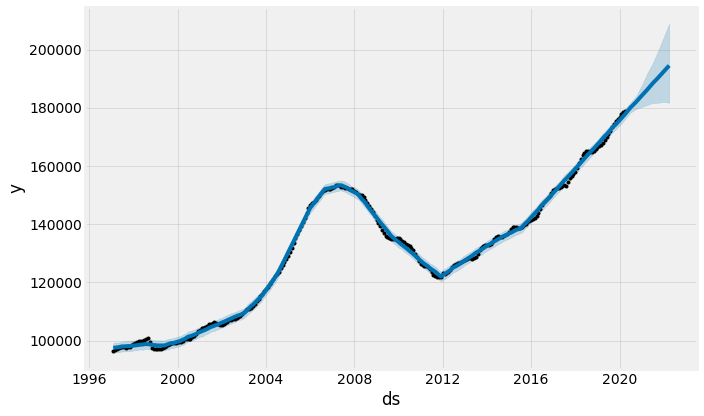

In [31]:
# MODEL

fay_model.plot(forecast_Fay, uncertainty=True)
plt.show()

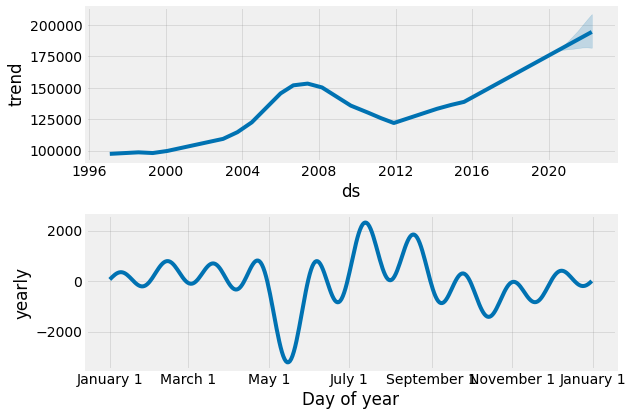

In [32]:
fig2 = fay_model.plot_components(forecast_Fay)

It looks like average housing prices in Fayetteville will at worst stay the same over the next two years, and at most will go up $30,000. Good time to buy; if you are selling you might want to wait.

# Part 2: Explore the data: US data by zipcode between 1997-2017

* Clean up the data, removing rows with too many blanks
* Summarize using descriptive statistics
* Visualize the data



In [33]:
# create a subset for US between 1997 and 2020

# reference: https://stackoverflow.com/questions/26347412/drop-multiple-columns-in-pandas
# reference: https://stackoverflow.com/questions/41307213/how-to-delete-columns-based-on-condition 
# sample: df.filter(regex='^(?!TYPE)|_1')
# reference: https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql
# sample: df[~df.countries.isin(countries)]
# #list(df.columns) 
#drop_years = df.filter(regex= '1996|2018|2019|2020')
#drop_years_col = list(drop_years.columns)
# reference: https://stackoverflow.com/questions/46346196/delete-data-frame-column-if-column-name-ends-with-some-string-python-3-6
# sample: You need chain conditions like df1 = df[df.columns[~(df.columns.str.endswith('Name') | df.columns.str.endswith('Code'))]] 



US_df = df[df.columns[~(df.columns.str.endswith('1996') | df.columns.str.endswith('2018') | df.columns.str.endswith('2019') | df.columns.str.endswith('2020')) ]]
US_df.head()


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,...,9/30/2014,10/31/2014,11/30/2014,12/31/2014,1/31/2015,2/28/2015,3/31/2015,4/30/2015,5/31/2015,6/30/2015,7/31/2015,8/31/2015,9/30/2015,10/31/2015,11/30/2015,12/31/2015,1/31/2016,2/29/2016,3/31/2016,4/30/2016,5/31/2016,6/30/2016,7/31/2016,8/31/2016,9/30/2016,10/31/2016,11/30/2016,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1362346.0,1372223.0,1364955.0,1359548.0,1355931.0,1363407.0,1360656.0,1356525.0,1350097.0,1355930.0,1362446.0,1375476.0,1380169.0,1388270.0,1405685.0,1423126.0,1441520.0,1450529.0,1465158.0,1476350.0,1488923.0,1493301.0,1499799.0,1501595.0,1505969.0,1512916.0,1516616.0,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,408057.0,416827.0,425087.0,432120.0,436962.0,441150.0,444482.0,447753.0,450885.0,455497.0,461395.0,...,865106.0,868136.0,873930.0,878722.0,883958.0,887873.0,893539.0,903862.0,912966.0,915000.0,916602.0,920152.0,923585.0,923550.0,923075.0,925654.0,930198.0,937742.0,940712.0,939954.0,937810.0,939442.0,944959.0,948398.0,948848.0,951644.0,957481.0,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1483695.0,1506505.0,1506459.0,1492425.0,1481633.0,1490441.0,1493792.0,1495385.0,1494490.0,1506862.0,1513489.0,1515314.0,1517631.0,1517245.0,1530045.0,1552474.0,1588831.0,1618914.0,1641329.0,1656455.0,1663833.0,1663526.0,1656955.0,1655092.0,1652724.0,1659755.0,1665784.0,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,204133.0,204600.0,206225.0,207084.0,207630.0,208343.0,209594.0,210422.0,211729.0,212988.0,214708.0,...,322038.0,324311.0,326645.0,329095.0,330953.0,332595.0,333221.0,334607.0,336254.0,337852.0,338657.0,339058.0,339256.0,339524.0,339194.0,339216.0,338213.0,336792.0,335632.0,335359.0,335612.0,334629.0,333488.0,332447.0,331849.0,331366.0,331334.0,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,630536.0,643350.0,654584.0,665638.0,674824.0,681464.0,686767.0,690649.0,696743.0,700375.0,707488.0,714017.0,...,1053486.0,1058741.0,1068436.0,1073244.0,1078594.0,1080392.0,1087034.0,1098788.0,1110803.0,1114983.0,1119110.0,1123493.0,1126324.0,1126873.0,1126939.0,1132571.0,1137512.0,1147776.0,115118

In [34]:
# drop rows with too many blanks
# reference: https://stackoverflow.com/questions/45515031/how-to-remove-columns-with-too-many-missing-values-in-python
# reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
# keep only rows with at least 2 non nans: df.dropna(thresh=2)
# there are 261 columns, so 240 allows for 11 blanks

US_df = US_df.dropna(thresh=250)
US_df.shape


(14343, 261)

In [35]:
# get rid of a few columns by name
US_df = US_df.drop(df.columns[[0, 3, 4, 7]], axis=1)
US_df.head()

,SizeRank,RegionName,State,City,CountyName,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,8/31/1999,9/30/1999,10/31/1999,11/30/1999,...,9/30/2014,10/31/2014,11/30/2014,12/31/2014,1/31/2015,2/28/2015,3/31/2015,4/30/2015,5/31/2015,6/30/2015,7/31/2015,8/31/2015,9/30/2015,10/31/2015,11/30/2015,12/31/2015,1/31/2016,2/29/2016,3/31/2016,4/30/2016,5/31/2016,6/30/2016,7/31/2016,8/31/2016,9/30/2016,10/31/2016,11/30/2016,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017
1,1,60657,IL,Chicago,Cook County,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,408057.0,416827.0,425087.0,432120.0,436962.0,441150.0,444482.0,447753.0,450885.0,455497.0,461395.0,467344.0,472584.0,477269.0,482728.0,...,865106.0,868136.0,873930.0,878722.0,883958.0,887873.0,893539.0,903862.0,912966.0,915000.0,916602.0,920152.0,923585.0,923550.0,923075.0,925654.0,930198.0,937742.0,940712.0,939954.0,937810.0,939442.0,944959.0,948398.0,948848.0,951644.0,957481.0,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0
3,3,77494,TX,Katy,Harris County,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,204133.0,204600.0,206225.0,207084.0,207630.0,208343.0,209594.0,210422.0,211729.0,212988.0,214708.0,215968.0,216236.0,216355.0,216868.0,...,322038.0,324311.0,326645.0,329095.0,330953.0,332595.0,333221.0,334607.0,336254.0,337852.0,338657.0,339058.0,339256.0,339524.0,339194.0,339216.0,338213.0,336792.0,335632.0,335359.0,335612.0,334629.0,333488.0,332447.0,331849.0,331366.0,331334.0,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0
4,4,60614,IL,Chicago,Cook County,566446.0,569659.0,573409.0,575403.0,581567.0,584316.0,587753.0,585957.0,583932.0,580996.0,578241.0,578355.0,580711.0,585527.0,591659.0,597955.0,604759.0,611702.0,620591.0,630536.0,643350.0,654584.0,665638.0,674824.0,681464.0,686767.0,690649.0,696743.0,700375.0,707488.0,714017.0,722142.0,727557.0,734938.0,742457.0,...,1053486.0,1058741.0,1068436.0,1073244.0,1078594.0,1080392.0,1087034.0,1098788.0,1110803.0,1114983.0,1119110.0,1123493.0,1126324.0,1126873.0,1126939.0,1132571.0,1137512.0,1147776.0,1151180.0,1153353.0,1151081.0,1153805.0,1158730.0,1162949.0,1163471.0,1166157.0,1172271.0,1173759.0,1175981.0,1174668.0,1182530.0,1188431.0,1192806.0,1193344.0,1191314.0,1192626.0,1196983.0,1199400.0,1199387.0,1202485.0
5,5,77449,TX,Katy,Harris County,97543.0,97263.0,97003.0,97138.0,97277.0,97514.0,97700.0,97747.0,97753.0,97983.0,98353.0,98624.0,99216.0,99691.0,100179.0,100044.0,100025.0,99914.0,99963.0,100017.0,100156.0,100335.0,100171.0,100043.0,100075.0,100624.0,101366.0,102021.0,102534.0,103033.0,103514.0,104007.0,104253.0,104323.0,104531.0,...,143993.0,145394.0,146658.0,148143.0,149467.0,150699.0,152187.0,153609.0,154983.0,155982.0,156749.0,157468.0,158336.0,159489.0,160265.0,160892.0,161934.0,163029.0,163711.0,163845.0,164375.0,165043.0,166075.0,166675.0,167139.0,167191.0,167965.0,168783.0,169116.0,169354.0,169752.0,170498.0,170828.0,171124.0,171168.0,171457.0,171930.0,172683.0,173177.0,173594.0
7,7,77084,TX,Houston,Harris County,96895.0,96481.0,96141.0,96098.0,96112.0,96101.0,96197.0,96209.0,96207.0,96265.0,96469.0,96676.0,97275.0,97791.0,98282.0,98270.0,98282.0,98292.0,98392.0,98459.0,98548.0,98625.0,98468.0,98328.0,98347.0,98858.0,99612.0,100329.0,100924.0,101504.0,102085.0,102708.0,103078.0,103289.0

In [0]:
#US_df.isna().any()

## Develop a base model for the US

* Forecast average median housing value by zip code for 2018
* Use the historical data from 1997 to 2017 as the training data

### Test code
Commented out for the report

In [0]:
#@title
#def practice(df, dfrow, newcol1):
 # several_values = [1,2,3,4]
  #df.loc[[dfrow][newcol1]] = 1
  #return 



In [0]:
#@title
#list_practice = [['two',2,2,2], ['three',3,3,3],['four', 4,4,4]]
#df_practice = pd.DataFrame(list_practice, columns =['index','A', 'B', 'C'])
#df_practice.index = df_practice['index']
#df_practice
#practice(df_practice, df_practice.loc['two',:], df_practice['C'])

In [0]:
#@title
#df_practice.loc['two','C'] = 1
#df_practice

In [0]:
#@title
# create a new dataframe that has columns for the forecasts we are going to make
#US_forecast_df = US_df.copy().reset_index(drop=True)
#newcols = ['1/31/2018', '2/28/2018', '3/31/2018', '4/30/2018', '5/31/2018', '6/30/2018', \
 #          '7/31/2018', '8/31/2018', '9/30/2018', '10/31/2018', '11/30/2018', '12/31/2018']
#for date in newcols:
 # US_forecast_df[date] = ""
#US_forecast_df.head()

In [0]:
#@title
#US_forecast_df.columns.get_loc("1/31/2018")

In [0]:
#@title
#
#US_forecast_df.head(3)

In [0]:
#@title
#def forecast_ts1(area):
 # area_ts = pd.DataFrame(area)
  #area_ts.reset_index(inplace=True)

  # turn it into a time series with columns that Prophet expects
#  area_ts = area_ts.rename(index=str, columns={3: "y", "index": "ds"})
 # area_ts.ds = pd.to_datetime(area_ts.ds)
  #print(area_ts.shape)
  #print(area_ts.head())
  
  # fit the model
  #prophet_model = Prophet(interval_width=0.95)
  #prophet_model.fit(area_ts)
  # forecast the next twelve months
  #future_12 = prophet_model.make_future_dataframe(periods=12, freq='M')
  ## future_12.tail(12)
  #forecast = prophet_model.predict(future_12)

  # return the estimates for each of the twelve months
  #return round(forecast[['ds','yhat']],0).tail(12)


In [0]:
#@title
#temp = US_df.iloc[1,5:260]
#new_temp = forecast_ts1(temp)
#new_temp

In [0]:
#@title
#def forecast_ts2(df, row, startcol, stopcol):
 # nextcol= stopcol+1

  #area_ts = pd.DataFrame(df.iloc[row, startcol:stopcol])
  #area_ts.reset_index(inplace=True)
  #print(area_ts.head())

  # turn it into a time series with columns that Prophet expects
  #area_ts = area_ts.rename(index=str, columns={0: "y", "index": "ds"})
  #area_ts.ds = pd.to_datetime(area_ts.ds)
  #print(area_ts.shape)
  #print(area_ts.head())
  
  # fit the model
  #prophet_model = Prophet(interval_width=0.95)
  #prophet_model.fit(area_ts)
  # forecast the next twelve months
  #future_12 = prophet_model.make_future_dataframe(periods=12, freq='M')
  ## future_12.tail(12)
  #forecast = prophet_model.predict(future_12)
  #forecast_series = round(forecast[['yhat']],0).tail(12)
  
  #for x in range(0, 11):
   # US_forecast_df.iloc[row, nextcol] = forecast_series.iloc[x, 'y']
    #nextcol = nextcol+1


  # return the estimates for each of the twelve months
  #return forecast_series

In [0]:
#@title
# create empty dataframe for predictions by month for 2018
# reference: https://thispointer.com/pandas-how-to-create-an-empty-dataframe-and-append-rows-columns-to-it-in-python/

#newcols = ['1/31/2018', '2/28/2018', '3/31/2018', '4/30/2018', '5/31/2018', '6/30/2018', \
 #          '7/31/2018', '8/31/2018', '9/30/2018', '10/31/2018', '11/30/2018', '12/31/2018']

#newrow = [('', '', '', '', '', '', '', '', '', '', '', '')]

#prediction_df = pd.DataFrame(data= newrow, columns = newcols)

#print(prediction_df.shape)

#print(prediction_df)

### Forecasting

In [45]:
US_df.reset_index(inplace = True, drop=True)
print(US_df.shape)
print(US_df.head())

(14343, 257)
   SizeRank  RegionName State  ... 10/31/2017 11/30/2017  12/31/2017
0         1       60657    IL  ...   960878.0   957985.0    958428.0
1         3       77494    TX  ...   331177.0   331223.0    332171.0
2         4       60614    IL  ...  1199400.0  1199387.0   1202485.0
3         5       77449    TX  ...   172683.0   173177.0    173594.0
4         7       77084    TX  ...   169293.0   169611.0    169797.0

[5 rows x 257 columns]


In [46]:
# create empty dataframe to put predictions into
prediction_df = US_df
prediction_df = prediction_df.reindex(prediction_df.columns.tolist() + ['1/31/2018', '2/28/2018', '3/31/2018', '4/30/2018', '5/31/2018', '6/30/2018', \
           '7/31/2018', '8/31/2018', '9/30/2018', '10/31/2018', '11/30/2018', '12/31/2018'], axis=1)
prediction_df.reset_index(inplace = True, drop=True)
prediction_df.drop(prediction_df.iloc[:, 0:257], inplace = True, axis = 1) 
prediction_df.head(1)

,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
def forecast_ts(df, row, startcol, stopcol):

  area_ts = pd.DataFrame(df.iloc[row, startcol:stopcol])
  area_ts.reset_index(inplace=True)
  #print(area_ts.head())

  # turn it into a time series with columns that Prophet expects
  area_ts = area_ts.rename(index=str, columns={"index": "ds", area_ts.columns[1]: "y"})
  #print(area_ts.head())
  area_ts.ds = pd.to_datetime(area_ts.ds)
  #print(area_ts.shape)
  #print(area_ts.head())
  
  # fit the model
  prophet_model = Prophet(interval_width=0.95)
  prophet_model.fit(area_ts)
  # forecast the next twelve months
  future_12 = prophet_model.make_future_dataframe(periods=12, freq='M')
  ## future_12.tail(12)
  forecast = prophet_model.predict(future_12)
  forecast_yhat = round(forecast[['yhat']],0).tail(12)
  #print(isinstance(forecast_yhat, pd.DataFrame))
  #print("forecast_yhat")
  #print(forecast_yhat.shape)
 
  for x in range(0, 12):
    #print("row is:", row)
    prediction_df.iloc[row, x] = forecast_yhat.iloc[x, 0]
    #print("row is:", row)
    #print("x is:", x)
     


  # return the estimates for each of the twelve months
  return forecast_yhat

In [48]:
print("prediction_df")
print(prediction_df.shape)


prediction_df
(14343, 12)


### Test code
Commented out for the report

In [0]:
#@title
# test
#prediction_df.iloc[1,1] = 9000
#prediction_df

In [0]:
#@title
# thing = forecast_ts(test_df, 1, 5, 256 )

In [0]:
#@title
# test i loop
# len(US_forecast_df.index)
#for i in range(len(US_forecast_df.index)):
#  print("i is:", i)

In [0]:
#@title
#test_df = US_df.iloc[0:3, :]
#test_df = test_df.reset_index(drop=True)
#test_df

In [0]:
#@title
# test
#for i in range(len(test_df.index)):
 # print("i is before call:", i)
  #forecast_ts(test_df, i, 5, 256 )
  #print("i is after call:", i)




### Run forecast

In [0]:
# COMMENTED OUT BECAUSE IT TAKES A LONG TIME TO RUN
#for i in range(14343):
 # forecast_ts(US_df, i, 5, 256 )
 # print(i)


In [59]:
# if you run the block above, write to csv
# prediction_df.to_csv('/content/drive/My Drive/US_predictions_biggest.csv') 

# otherwise read results of previous run
prediction_df = pd.read_csv('/content/drive/My Drive/US_predictions_biggest.csv', sep=',')
prediction_df.head(3) 

,Unnamed: 0,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018
0,0,993168.0,996074.0,999639.0,1002791.0,1005924.0,1008620.0,1011387.0,1014627.0,1017948.0,1021120.0,1023694.0,1026331.0
1,1,353346.0,354118.0,355106.0,356365.0,357499.0,358607.0,359701.0,360771.0,361789.0,362781.0,363931.0,365036.0
2,2,1230633.0,1234926.0,1238873.0,1244347.0,1249671.0,1253993.0,1257348.0,1261141.0,1265241.0,1269928.0,1274357.0,1278905.0


In [60]:
print(prediction_df.shape)

#prediction_df.describe()

(14343, 13)


In [61]:
# merge US_df and prediction_df
# pd.merge(left, right, how='inner', left_index=False, right_index=False, sort=True)
US_forecast_df = pd.merge(left=US_df, right=prediction_df, left_on=US_df.index, right_on=prediction_df.index)
US_forecast_df.head(2)


,key_0,SizeRank,RegionName,State,City,CountyName,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,8/31/1999,9/30/1999,10/31/1999,...,10/31/2015,11/30/2015,12/31/2015,1/31/2016,2/29/2016,3/31/2016,4/30/2016,5/31/2016,6/30/2016,7/31/2016,8/31/2016,9/30/2016,10/31/2016,11/30/2016,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,Unnamed: 0,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018
0,0,1,60657,IL,Chicago,Cook County,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,408057.0,416827.0,425087.0,432120.0,436962.0,441150.0,444482.0,447753.0,450885.0,455497.0,461395.0,467344.0,472584.0,477269.0,...,923550.0,923075.0,925654.0,930198.0,937742.0,940712.0,939954.0,937810.0,939442.0,944959.0,948398.0,948848.0,951644.0,957481.0,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,0,993168.0,996074.0,999639.0,1002791.0,1005924.0,1008620.0,1011387.0,1014627.0,1017948.0,1021120.0,1023694.0,1026331.0
1,1,3,77494,TX,Katy,Harris County,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,204133.0,204600.0,206225.0,207084.0,207630.0,208343.0,209594.0,210422.0,211729.0,212988.0,214708.0,215968.0,216236.0,216355.0,...,339524.0,339194.0,339216.0,338213.0,336792.0,335632.0,335359.0,335612.0,334629.0,333488.0,332447.0,331849.0,331366.0,331334.0,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,1,353346.0,354118.0,355106.0,356365.0,357499.0,358607.0,359701.0,360771.0,361789.0,362781.0,363931.0,365036.0


In [62]:
US_forecast_df = US_forecast_df.drop(columns=['key_0', 'Unnamed: 0'])
US_forecast_df.head(2)

,SizeRank,RegionName,State,City,CountyName,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,8/31/1999,9/30/1999,10/31/1999,11/30/1999,...,9/30/2015,10/31/2015,11/30/2015,12/31/2015,1/31/2016,2/29/2016,3/31/2016,4/30/2016,5/31/2016,6/30/2016,7/31/2016,8/31/2016,9/30/2016,10/31/2016,11/30/2016,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018
0,1,60657,IL,Chicago,Cook County,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,400292.0,408057.0,416827.0,425087.0,432120.0,436962.0,441150.0,444482.0,447753.0,450885.0,455497.0,461395.0,467344.0,472584.0,477269.0,482728.0,...,923585.0,923550.0,923075.0,925654.0,930198.0,937742.0,940712.0,939954.0,937810.0,939442.0,944959.0,948398.0,948848.0,951644.0,957481.0,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,993168.0,996074.0,999639.0,1002791.0,1005924.0,1008620.0,1011387.0,1014627.0,1017948.0,1021120.0,1023694.0,1026331.0
1,3,77494,TX,Katy,Harris County,201687.0,202931.0,204207.0,206413.0,208870.0,210582.0,210250.0,212394.0,214904.0,217109.0,216177.0,214468.0,211736.0,210126.0,208420.0,207481.0,206443.0,206033.0,205925.0,204647.0,204133.0,204600.0,206225.0,207084.0,207630.0,208343.0,209594.0,210422.0,211729.0,212988.0,214708.0,215968.0,216236.0,216355.0,216868.0,...,339256.0,339524.0,339194.0,339216.0,338213.0,336792.0,335632.0,335359.0,335612.0,334629.0,333488.0,332447.0,331849.0,331366.0,331334.0,331031.0,330770.0,331485.0,332276.0,332365.0,331319.0,331016.0,331256.0,331356.0,331165.0,331177.0,331223.0,332171.0,353346.0,354118.0,355106.0,356365.0,357499.0,358607.0,359701.0,360771.0,361789.0,362781.0,363931.0,365036.0


In [0]:
# save the merged file 
# US_forecast_df.to_csv('/content/drive/My Drive/temp_allcol_forecast.csv')
#US_forecast_df.to_csv('/content/drive/My Drive/allcol_forecast.csv')

In [64]:
forecast_rec = US_forecast_df.loc[0:2000, ['SizeRank', 'RegionName', 'State', 'City', 'CountyName', '12/31/2015', '12/31/2017', '12/31/2018']]
print(forecast_rec.shape)
print(forecast_rec.head())

(2001, 8)
   SizeRank  RegionName State  ... 12/31/2015 12/31/2017  12/31/2018
0         1       60657    IL  ...   925654.0   958428.0   1026331.0
1         3       77494    TX  ...   339216.0   332171.0    365036.0
2         4       60614    IL  ...  1132571.0  1202485.0   1278905.0
3         5       77449    TX  ...   160892.0   173594.0    191846.0
4         7       77084    TX  ...   158653.0   169797.0    186377.0

[5 rows x 8 columns]


### Add calculated columns and ranks

In [65]:
forecast_rec['1year_change'] = ((forecast_rec['12/31/2018'] - forecast_rec['12/31/2017'])/ forecast_rec['12/31/2017']) *100
forecast_rec['3year_change'] = ((forecast_rec['12/31/2018'] - forecast_rec['12/31/2015'])/ forecast_rec['12/31/2015']) * 100
#forecast_rec['1year_change'] = forecast_rec['12/31/2018'] - forecast_rec['12/31/2017']
#forecast_rec['3year_change'] = forecast_rec['12/31/2018'] - forecast_rec['12/31/2015']
forecast_rec['1year_Rank'] = forecast_rec['1year_change'].rank(method='max') # we want the highest 1 year change
forecast_rec['3year_Rank'] = forecast_rec['3year_change'].rank(method='max') # we want the highest 3 year change
forecast_rec['Bargain_Rank'] = forecast_rec['12/31/2017'].rank(method='min') # we want the lowest price


print(forecast_rec.shape)
# reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rank.html
# reference: https://pythonhealthcare.org/2018/04/05/29-sorting-and-ranking-with-pandas/
# sample: df['max_rank'] = df['Number_legs'].rank(method='max')
# sample: sort_values(['magic_power','aggression']...

(2001, 13)


In [66]:
forecast_rec.head(2)

,SizeRank,RegionName,State,City,CountyName,12/31/2015,12/31/2017,12/31/2018,1year_change,3year_change,1year_Rank,3year_Rank,Bargain_Rank
0,1,60657,IL,Chicago,Cook County,925654.0,958428.0,1026331.0,7.084831,10.876310,1664.0,422.0,1866.0
1,3,77494,TX,Katy,Harris County,339216.0,332171.0,365036.0,9.894000,7.611669,1903.0,246.0,1206.0


In [67]:
# SizeRank was in the original dataset, small number is largest population   # we want the largest population
forecast_rec = forecast_rec[forecast_rec['1year_change']>0]
forecast_rec = forecast_rec[forecast_rec['3year_change']>0]
print(forecast_rec.shape)

(1697, 13)


In [68]:
forecast_rec['SumRank'] = forecast_rec['SizeRank'] + forecast_rec['1year_Rank'] + forecast_rec['3year_Rank'] + forecast_rec['Bargain_Rank']
forecast_rec['CityRank'] = forecast_rec['SumRank'].rank(method='first') 
print(forecast_rec.shape)

(1697, 15)


In [0]:
forecast_rec = forecast_rec.sort_values(['CityRank']) # we want the lowest combined rank, ascending is the default for sort_values

In [70]:
print(forecast_rec.shape)
forecast_rec.head()

(1697, 15)


,SizeRank,RegionName,State,City,CountyName,12/31/2015,12/31/2017,12/31/2018,1year_change,3year_change,1year_Rank,3year_Rank,Bargain_Rank,SumRank,CityRank
5,8,79936,TX,El Paso,El Paso County,119021.0,124216.0,124417.0,0.161815,4.533654,331.0,103.0,144.0,586.0,1.0
110,127,79938,TX,El Paso,El Paso County,146907.0,150596.0,151331.0,0.488061,3.011429,404.0,58.0,286.0,875.0,2.0
61,78,21234,MD,Parkville,Baltimore County,199926.0,209834.0,209958.0,0.059094,5.017857,312.0,115.0,620.0,1125.0,3.0
91,108,44035,OH,Elyria,Lorain County,90053.0,98958.0,100197.0,1.252046,11.264478,538.0,457.0,63.0,1166.0,4.0
382,445,36117,AL,Montgomery,Montgomery County,170383.0,170683.0,171088.0,0.237282,0.413774,353.0,27.0,401.0,1226.0,5.0


### Intial set of recommendations

Using only pricing data, we have a set of recommendations ranking the zip codes by how much they've increased and how cheap they are. 


## Get additional data on states
The current model with zipcode-level data has a few flaws. It would helpful to add things like employment rates, consumer spending, and business trends. However, people frequently live in one zip code and shop or work in another. [In a small town, it is more likely that you would stay in one zip code, but our model has prioritized cities with higher populations, where it is less likely to stay in one zip code.) Though it is true that someone could cross state lines, it is less likely than someone crossing city or county lines. 

We are going to add some additional data at the state level. 

In [71]:
state_rank = forecast_rec.loc[:, ['State', 'CityRank']]
state_rank = state_rank.groupby('State').mean().reset_index()
state_rank = state_rank.rename(columns={"State": "StateAbbr"})
state_rank = state_rank.rename(columns={'CityRank': 'AvgCityRank'})
state_rank = state_rank.sort_values(['AvgCityRank']).reset_index(drop=True)
state_rank.head(5)

,StateAbbr,AvgCityRank
0,ME,55.000
1,OK,153.875
2,IN,156.500
3,WV,173.250
4,CT,210.000


In [72]:
# get employment rates by state
# data source: Bureau of Labor Statistics https://www.bls.gov/web/laus/laumstrk.htm

employment = pd.read_csv('/content/drive/My Drive/Unemployment.csv')
employment.head()

,StateAbbr,State,UnempRate,EmpRate,UnempRank,EmpRank
0,AK,Alaska,5.6,94.4,44,8
1,AL,Alabama,3.5,96.5,18,34
2,AR,Arkansas,4.8,95.2,37,15
3,AZ,Arizona,5.5,94.5,42,10
4,CA,California,5.3,94.7,40,12


In [73]:
# get business data by state
# data source: US Census https://www.census.gov/data/tables/2017/econ/susb/2017-susb-annual.html

businesses = pd.read_csv('/content/drive/My Drive/BusinessesData.csv')
businesses['PayPerBusi'] = round(businesses['PayPerBusi'], 0)

businesses.head()

,StateAbbr,GeoName,BusinessCount,EMPLOYMENT,PayrollThous,PayPerBusi,BusiRank,PayRank
0,AK,Alaska,17147,262075,15007844,875.0,51,34
1,AL,Alabama,74288,1690061,71746399,966.0,26,27
2,AR,Arkansas,50929,1030593,42305514,831.0,34,41
3,AZ,Arizona,109780,2448538,113490959,1034.0,19,21
4,CA,California,763803,14896625,955043843,1250.0,1,4


In [74]:
# get consumer spending
# data source: Bureau of Economic Analysis https://www.bea.gov/data/consumer-spending/state

spending = pd.read_csv('/content/drive/My Drive/Spending.csv')
spending.head()

,StateAbbr,StateName,Spending,EatingOut,SpendingRank,EatingOutRank
0,AK,Alaska,50246,4097,7,5
1,AL,Alabama,33904,2747,50,46
2,AR,Arkansas,34095,2697,49,50
3,AZ,Arizona,35906,2829,44,44
4,CA,California,46981,2987,12,29


In [75]:
# add employment ranks to city rank
state_rank = state_rank.merge(employment, on='StateAbbr')
state_rank.head()

,StateAbbr,AvgCityRank,State,UnempRate,EmpRate,UnempRank,EmpRank
0,ME,55.000,Maine,3.2,96.8,10,41
1,OK,153.875,Oklahoma,3.1,96.9,7,43
2,IN,156.500,Indiana,3.2,96.8,10,42
3,WV,173.250,West Virginia,6.1,93.9,49,3
4,CT,210.000,Connecticut,3.7,96.3,22,30


In [76]:
# add business data

state_rank = state_rank.merge(businesses, on='StateAbbr')
state_rank.head()

,StateAbbr,AvgCityRank,State,UnempRate,EmpRate,UnempRank,EmpRank,GeoName,BusinessCount,EMPLOYMENT,PayrollThous,PayPerBusi,BusiRank,PayRank
0,ME,55.000,Maine,3.2,96.8,10,41,Maine,34190,513745,22349651,654.0,39,47
1,OK,153.875,Oklahoma,3.1,96.9,7,43,Oklahoma,72912,1360720,59669532,818.0,27,43
2,IN,156.500,Indiana,3.2,96.8,10,42,Indiana,109706,2779124,122892875,1120.0,20,15
3,WV,173.250,West Virginia,6.1,93.9,49,3,West Virginia,26749,549413,22287060,833.0,42,38
4,CT,210.000,Connecticut,3.7,96.3,22,30,Connecticut,71198,1536858,95781512,1345.0,28,3


In [77]:
# add spending data

state_rank = state_rank.merge(spending, on='StateAbbr')
state_rank.head()

,StateAbbr,AvgCityRank,State,UnempRate,EmpRate,UnempRank,EmpRank,GeoName,BusinessCount,EMPLOYMENT,PayrollThous,PayPerBusi,BusiRank,PayRank,StateName,Spending,EatingOut,SpendingRank,EatingOutRank
0,ME,55.000,Maine,3.2,96.8,10,41,Maine,34190,513745,22349651,654.0,39,47,Maine,45497,4323,15,4
1,OK,153.875,Oklahoma,3.1,96.9,7,43,Oklahoma,72912,1360720,59669532,818.0,27,43,Oklahoma,34500,2440,48,51
2,IN,156.500,Indiana,3.2,96.8,10,42,Indiana,109706,2779124,122892875,1120.0,20,15,Indiana,37680,2762,37,45
3,WV,173.250,West Virginia,6.1,93.9,49,3,West Virginia,26749,549413,22287060,833.0,42,38,West Virginia,36071,2921,43,37
4,CT,210.000,Connecticut,3.7,96.3,22,30,Connecticut,71198,1536858,95781512,1345.0,28,3,Connecticut,52941,3400,3,15


In [78]:
state_ranks_only = state_rank.loc[:, ['StateAbbr', 'AvgCityRank', 'State', 'EmpRank', 'BusiRank', 'PayRank', 'SpendingRank', 'EatingOutRank']]
state_ranks_only['RankSum'] = state_ranks_only['AvgCityRank'] + state_ranks_only['EmpRank'] + state_ranks_only['BusiRank'] + state_ranks_only['PayRank'] + state_ranks_only['SpendingRank'] + state_ranks_only['EatingOutRank']
state_ranks_only['TotalStateRank'] = state_ranks_only['RankSum'].rank()
state_ranks_only.sort_values(by='TotalStateRank').head()

,StateAbbr,AvgCityRank,State,EmpRank,BusiRank,PayRank,SpendingRank,EatingOutRank,RankSum,TotalStateRank
0,ME,55.000000,Maine,41,39,47,15,4,201.000000,1.0
4,CT,210.000000,Connecticut,30,28,3,3,15,289.000000,2.0
2,IN,156.500000,Indiana,42,20,15,37,45,315.500000,3.0
3,WV,173.250000,West Virginia,3,42,38,43,37,336.250000,4.0
5,KY,225.823529,Kentucky,7,29,23,46,20,350.823529,5.0


## Develop a second model, using state data


What if we looked at things at the state level instead of the zip code level. Which states are the strongest?

In [79]:
forecast_rec2 = forecast_rec
forecast_rec2 = forecast_rec2.loc[:, ['RegionName', 'State', 'City', 'CityRank'] ]
forecast_rec2 = forecast_rec2.rename(columns={"RegionName": "Zipcode", "State": "StateAbbr"})

forecast_rec2.head()

,Zipcode,StateAbbr,City,CityRank
5,79936,TX,El Paso,1.0
110,79938,TX,El Paso,2.0
61,21234,MD,Parkville,3.0
91,44035,OH,Elyria,4.0
382,36117,AL,Montgomery,5.0


In [80]:
forecast_rec2 = forecast_rec2.merge(state_ranks_only, on='StateAbbr')
forecast_rec2 = forecast_rec2.loc[:, ['Zipcode', 'StateAbbr', 'City', 'CityRank', 'TotalStateRank']]
forecast_rec2['Rec2RankProduct'] = (forecast_rec2['CityRank'] * forecast_rec2['TotalStateRank'])
# state_rank['TotalStateRank'] = state_rank['RankSum'].rank()
forecast_rec2['Rec2Rank'] = forecast_rec2['Rec2RankProduct'].rank()
forecast_rec2.head(3)

,Zipcode,StateAbbr,City,CityRank,TotalStateRank,Rec2RankProduct,Rec2Rank
0,79936,TX,El Paso,1.0,34.0,34.0,2.0
1,79938,TX,El Paso,2.0,34.0,68.0,12.0
2,79928,TX,Horizon City,10.0,34.0,340.0,29.0


In [81]:
forecast_rec2.sort_values(by='Rec2Rank')

,Zipcode,StateAbbr,City,CityRank,TotalStateRank,Rec2RankProduct,Rec2Rank
208,44035,OH,Elyria,4.0,7.0,28.0,1.0
0,79936,TX,El Paso,1.0,34.0,34.0,2.0
178,21234,MD,Parkville,3.0,15.0,45.0,3.0
300,73160,OK,Moore,8.0,6.0,48.0,4.0
209,44077,OH,Painesville,7.0,7.0,49.0,5.0
...,...,...,...,...,...,...,...
1673,80221,CO,Sherrelwood,1669.0,44.0,73436.0,1693.0
1674,80206,CO,Denver,1675.0,44.0,73700.0,1694.0
1675,80128,CO,Ken Caryl,1676.0,44.0,73744.0,1695.0
1676,80204,CO,Denver,1680.0,44.0,73920.0,1696.0


In [82]:
state_rec2 = forecast_rec2.groupby(by='StateAbbr').mean().reset_index()
state_rec2 = state_rec2.sort_values(by='Rec2Rank')
print(min(state_rec2['Rec2Rank']))
print(max(state_rec2['Rec2Rank']))
state_rec2.head(3)

6.5
1537.5348837209303


,StateAbbr,Zipcode,CityRank,TotalStateRank,Rec2RankProduct,Rec2Rank
20,ME,4401.0,55.0,1.0,55.0,6.5
6,CT,6810.0,210.0,2.0,420.0,40.5
14,IN,47553.0,156.5,3.0,469.5,47.5


(array([8., 8., 4., 6., 4., 4., 4., 1., 2., 2.]),
 array([   6.5       ,  159.60348837,  312.70697674,  465.81046512,
         618.91395349,  772.01744186,  925.12093023, 1078.2244186 ,
        1231.32790698, 1384.43139535, 1537.53488372]),
 <a list of 10 Patch objects>)

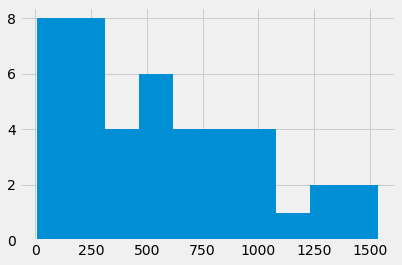

In [83]:
plt.hist(state_rec2['Rec2Rank'])

In [84]:
rank_map = state_rec2.loc[:, ['StateAbbr', 'Rec2Rank'] ]
#rank_map['Color'] 
rank_map.head()

,StateAbbr,Rec2Rank
20,ME,6.5000
6,CT,40.5000
14,IN,47.5000
42,WV,56.7500
31,OK,75.5625


In [131]:
# reference: https://plotly.com/python/choropleth-maps/

import plotly.graph_objects as go

# Load data frame and tidy it.
import pandas as pd
df = state_rec2

fig = go.Figure(data=go.Choropleth(
    locations=df['StateAbbr'], # Spatial coordinates
    z = df['Rec2Rank'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = 'States to invest in in light orange (model 2, emphasizing bargains)',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

## Third model, using random forest

Here, we'll use random forest to identify which attributes have the biggest impact on the 12/31/2018 price. We can use this information to prioritize the zip codes. The by-state information will be added in to the zip-code level information. 

In [86]:
# reminding ourselves what the by-city data looks like
forecast_rec_all = forecast_rec
forecast_rec_all = forecast_rec_all.rename(columns= {'State':'StateAbbr', 'RegionName':'Zipcode'})
isinstance(forecast_rec_all, pd.DataFrame)
forecast_rec_all.shape
forecast_rec_all.head(4)


,SizeRank,Zipcode,StateAbbr,City,CountyName,12/31/2015,12/31/2017,12/31/2018,1year_change,3year_change,1year_Rank,3year_Rank,Bargain_Rank,SumRank,CityRank
5,8,79936,TX,El Paso,El Paso County,119021.0,124216.0,124417.0,0.161815,4.533654,331.0,103.0,144.0,586.0,1.0
110,127,79938,TX,El Paso,El Paso County,146907.0,150596.0,151331.0,0.488061,3.011429,404.0,58.0,286.0,875.0,2.0
61,78,21234,MD,Parkville,Baltimore County,199926.0,209834.0,209958.0,0.059094,5.017857,312.0,115.0,620.0,1125.0,3.0
91,108,44035,OH,Elyria,Lorain County,90053.0,98958.0,100197.0,1.252046,11.264478,538.0,457.0,63.0,1166.0,4.0


In [87]:
# remembering what state_rank looks like
state_rank.head(4)

,StateAbbr,AvgCityRank,State,UnempRate,EmpRate,UnempRank,EmpRank,GeoName,BusinessCount,EMPLOYMENT,PayrollThous,PayPerBusi,BusiRank,PayRank,StateName,Spending,EatingOut,SpendingRank,EatingOutRank
0,ME,55.000,Maine,3.2,96.8,10,41,Maine,34190,513745,22349651,654.0,39,47,Maine,45497,4323,15,4
1,OK,153.875,Oklahoma,3.1,96.9,7,43,Oklahoma,72912,1360720,59669532,818.0,27,43,Oklahoma,34500,2440,48,51
2,IN,156.500,Indiana,3.2,96.8,10,42,Indiana,109706,2779124,122892875,1120.0,20,15,Indiana,37680,2762,37,45
3,WV,173.250,West Virginia,6.1,93.9,49,3,West Virginia,26749,549413,22287060,833.0,42,38,West Virginia,36071,2921,43,37


In [88]:
state_raw = state_rank.drop(columns= ['State', 'UnempRate', 'UnempRank', 'EmpRank', 'GeoName', 'PayrollThous', 'BusiRank', 'PayRank', 'StateName', 'SpendingRank', 'EatingOutRank'])
state_raw = state_raw.rename(columns={'EMPLOYMENT': 'EmpCount'})
state_raw.head(3)

,StateAbbr,AvgCityRank,EmpRate,BusinessCount,EmpCount,PayPerBusi,Spending,EatingOut
0,ME,55.000,96.8,34190,513745,654.0,45497,4323
1,OK,153.875,96.9,72912,1360720,818.0,34500,2440
2,IN,156.500,96.8,109706,2779124,1120.0,37680,2762


In [89]:
forecast_rec3 = forecast_rec_all.merge(state_raw, on='StateAbbr')
forecast_rec3.head(3)

,SizeRank,Zipcode,StateAbbr,City,CountyName,12/31/2015,12/31/2017,12/31/2018,1year_change,3year_change,1year_Rank,3year_Rank,Bargain_Rank,SumRank,CityRank,AvgCityRank,EmpRate,BusinessCount,EmpCount,PayPerBusi,Spending,EatingOut
0,8,79936,TX,El Paso,El Paso County,119021.0,124216.0,124417.0,0.161815,4.533654,331.0,103.0,144.0,586.0,1.0,861.022472,95.3,442641,10580160,1231.0,39045,2969
1,127,79938,TX,El Paso,El Paso County,146907.0,150596.0,151331.0,0.488061,3.011429,404.0,58.0,286.0,875.0,2.0,861.022472,95.3,442641,10580160,1231.0,39045,2969
2,633,79928,TX,Horizon City,El Paso County,138938.0,143154.0,144180.0,0.716711,3.772906,442.0,78.0,251.0,1404.0,10.0,861.022472,95.3,442641,10580160,1231.0,39045,2969


In [0]:
forecast_rec3['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(forecast_rec3))
forecast_rec3_train = forecast_rec3[forecast_rec3['runiform'] >= 0.33]
forecast_rec3_test = forecast_rec3[forecast_rec3['runiform'] < 0.33]

In [91]:
rf_model_maker = RandomForestRegressor(random_state = 9999)

y_train = forecast_rec3_train.loc[:, ['12/31/2018']]

# full model has more predictors
X_train = forecast_rec3_train.loc[:, \
    ['SizeRank',    '3year_change', 'AvgCityRank',\
         'EmpRate',  'BusinessCount', 'EmpCount', 'PayPerBusi', 'Spending', 'EatingOut']] #'12/31/2015',
X_test = forecast_rec3_test.loc[:, \
    ['SizeRank',  '3year_change', 'AvgCityRank',\
         'EmpRate',  'BusinessCount', 'EmpCount', 'PayPerBusi', 'Spending', 'EatingOut']] #'12/31/2015',  

rf_model_fit = rf_model_maker.fit(X_train, y_train)

# compute the proportion of response variance for training data
forecast_rec3_train['rf_predict_2018_value'] =\
    rf_model_fit.predict(X_train)
rf_train_result = \
    round(np.power(forecast_rec3_train['12/31/2018']\
        .corr(forecast_rec3_train['rf_predict_2018_value']),2),3)
print('\nRandom Forest Prop of Training Set Variance Accounted for: ',\
    rf_train_result)

# compute the proportion of response variance for test data
forecast_rec3_test['rf_predict_2018_value'] =\
    rf_model_fit.predict(X_test)
rf_test_result = \
    round(np.power(forecast_rec3_test['12/31/2018']\
        .corr(forecast_rec3_test['rf_predict_2018_value']),2),3)
print('\nRandom Forest Prop of Test Set Variance Accounted for: ',\
    rf_test_result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




Random Forest Prop of Training Set Variance Accounted for:  0.909

Random Forest Prop of Test Set Variance Accounted for:  0.3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



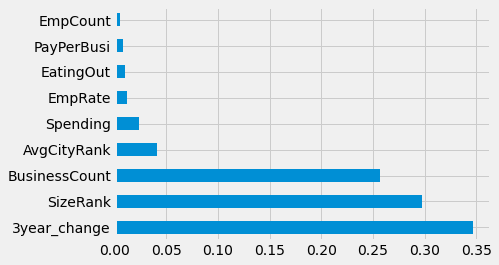

In [92]:
feat_importances = pd.Series(rf_model_fit.feature_importances_, index=X_train.columns)
feat_importances.nlargest(9).plot(kind='barh')

In [93]:
# there is a big difference between train and test results, which means we are likely overfitting
# remove 3-year change and see what we get

y_train = forecast_rec3_train.loc[:, ['12/31/2018']]

# full model has more predictors
X_train = forecast_rec3_train.loc[:, \
    ['AvgCityRank',\
         'EmpRate',  'BusinessCount', 'EmpCount', 'PayPerBusi', 'Spending', 'EatingOut']] #'12/31/2015',
X_test = forecast_rec3_test.loc[:, \
    ['AvgCityRank',\
         'EmpRate',  'BusinessCount', 'EmpCount', 'PayPerBusi', 'Spending', 'EatingOut']] #'12/31/2015',  

rf_model_fit = rf_model_maker.fit(X_train, y_train)

# compute the proportion of response variance for training data
forecast_rec3_train['rf_predict_2018_value'] =\
    rf_model_fit.predict(X_train)
rf_train_result = \
    round(np.power(forecast_rec3_train['12/31/2018']\
        .corr(forecast_rec3_train['rf_predict_2018_value']),2),3)
print('\nRandom Forest Prop of Training Set Variance Accounted for: ',\
    rf_train_result)

# compute the proportion of response variance for test data
forecast_rec3_test['rf_predict_2018_value'] =\
    rf_model_fit.predict(X_test)
rf_test_result = \
    round(np.power(forecast_rec3_test['12/31/2018']\
        .corr(forecast_rec3_test['rf_predict_2018_value']),2),3)
print('\nRandom Forest Prop of Test Set Variance Accounted for: ',\
    rf_test_result)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




Random Forest Prop of Training Set Variance Accounted for:  0.305

Random Forest Prop of Test Set Variance Accounted for:  0.338


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



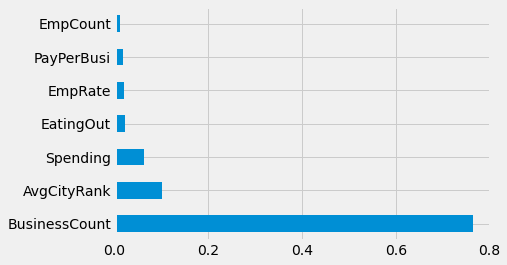

In [94]:
# accuracy goes way down when we remove SizeRank and 3-year change
# looking at the remainder for these for prioritizing the results

feat_importances = pd.Series(rf_model_fit.feature_importances_, index=X_train.columns)
feat_importances.nlargest(9).plot(kind='barh')

In [0]:
top100 = forecast_rec3.sort_values(by=['1year_change', '3year_change', 'BusinessCount', 'AvgCityRank', 'Spending', 'EatingOut', 'EmpRate'], ascending=False).head(100) 
#df.drop(columns =['C', 'D']
top100 = top100.drop(columns=['12/31/2015','1year_Rank', '3year_Rank', 'Bargain_Rank', 'SumRank', 'CityRank',  'BusinessCount', 'EmpCount',  'runiform' ])
top10_by1 = top100.head(10)
top10_by3 = top100.sort_values(by= ['3year_change', 'AvgCityRank', 'Spending', 'EatingOut', 'EmpRate'], ascending=False).head(10) 



In [148]:
top10_by1.sort_values(by='12/31/2017').head(3)

,SizeRank,Zipcode,StateAbbr,City,CountyName,12/31/2017,12/31/2018,1year_change,3year_change,AvgCityRank,EmpRate,PayPerBusi,Spending,EatingOut
171,2228,77035,TX,Houston,Harris County,238887.0,280947.0,17.606651,20.252449,861.022472,95.3,1231.0,39045,2969
156,1650,77080,TX,Houston,Harris County,256872.0,297101.0,15.661107,19.639111,861.022472,95.3,1231.0,39045,2969
1413,731,70119,LA,New Orleans,Orleans Parish,272004.0,319009.0,17.280996,21.232124,707.111111,93.1,926.0,36104,2876


In [149]:
top10_by3.sort_values(by='12/31/2017').head(3)

,SizeRank,Zipcode,StateAbbr,City,CountyName,12/31/2017,12/31/2018,1year_change,3year_change,AvgCityRank,EmpRate,PayPerBusi,Spending,EatingOut
139,1180,75227,TX,Dallas,Dallas County,130211.0,144280.0,10.804771,59.628257,861.022472,95.3,1231.0,39045,2969
93,482,75211,TX,Dallas,Dallas County,131593.0,146650.0,11.442098,51.018979,861.022472,95.3,1231.0,39045,2969
123,883,75149,TX,Mesquite,Dallas County,139503.0,155700.0,11.610503,50.176508,861.022472,95.3,1231.0,39045,2969


In [157]:
full_df.head(3)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1/31/1996,2/29/1996,3/31/1996,4/30/1996,5/31/1996,6/30/1996,7/31/1996,8/31/1996,9/30/1996,10/31/1996,11/30/1996,12/31/1996,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,...,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017,1/31/2018,2/28/2018,3/31/2018,4/30/2018,5/31/2018,6/30/2018,7/31/2018,8/31/2018,9/30/2018,10/31/2018,11/30/2018,12/31/2018,1/31/2019,2/28/2019,3/31/2019,4/30/2019,5/31/2019,6/30/2019,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1524562.0,1525605.0,1525955.0,1528604.0,1527843.0,1530509.0,1525013.0,1531236.0,1532307.0,1543260.0,1534946.0,1527048.0,1508495.0,1498638.0,1494872,1487969,1480591,1471324,1462476,1456223,1448110,1446622,1451579,1452858,1453112,1439554,1426900,1416568,1415022,1414474,1413747,1405862,1402547,1390420,1381621,1375725,1374714,1381453,1385737,1389268
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,364892.0,364162.0,363605.0,362963.0,361660.0,361342.0,360662.0,361804.0,363561.0,366592.0,370077.0,372842.0,376806.0,380122.0,384081.0,385663.0,389062.0,389359.0,390182.0,388087.0,385729.0,381688.0,377848.0,376493.0,374914.0,375094.0,375012.0,378067.0,380789.0,386605.0,392801.0,...,958178.0,956528.0,951529.0,955244.0,958096.0,959882.0,958726.0,956879.0,958371.0,961171.0,960878.0,957985.0,958428.0,964051.0,969547,968807,968566,969572,972936,973010,972447,972684,975094,978629,981362,979667,976810,975419,975366,975741,974693,975616,975734,975251,974238,973104,971908,972038,973671,975642
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1669910.0,1661199.0,1639318.0,1622378.0,1613382.0,1611625.0,1609075.0,1611388.0,1615755.0,1619823.0,1609176.0,1597282.0,1581756.0,1572273.0,1573601,1578799,1585506,1587796,1591265,1596660,1598258,1596017,1595032,1592948,1590038,1576594,1562766,1552128,1545711,1540137,1528603,1514894,1502233,1492429,1486122,1480426,1476509,1478980,1479301,1474994


In [172]:
# reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
# frames = [df1, df2, df3]
# result = pd.concat(frames)
# reference: https://stackoverflow.com/questions/17978133/python-pandas-merge-only-certain-columns
# You want to use TWO brackets, so if you are doing a VLOOKUP sort of action:
# df = pd.merge(df,df2[['Key_Column','Target_Column']],on='Key_Column', how='left')

# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/
#expected = [0.0, 0.5, 0.0, 0.5, 0.0]
#predictions = [0.2, 0.4, 0.1, 0.6, 0.2]
#mse = mean_squared_error(expected, predictions)
#rmse = sqrt(mse)
#print('RMSE: %f' % rmse)

# https://stackoverflow.com/questions/40353519/how-to-apply-custom-function-to-pandas-data-frame-for-each-row/54145945
# facts['pop2050'] = facts.apply(lambda row: final_pop(row['population'],row['population_growth']),axis=1)

def root_mse(expected, predicted):
  mse= mean_squared_error(expected, predicted)
  rmse = sqrt(mse)
  return rmse


frames = [top10_by1, top10_by3]
top20ish = pd.concat(frames)
print(top20ish.shape)
top20ish= pd.merge(top20ish, 
                   full_df[['RegionName', '12/31/2018']],
                   left_on='Zipcode',
                   right_on='RegionName',
                   how='left'
                   )
top20ish = top20ish.drop(columns='RegionName')
top20ish = top20ish.rename(columns= {'12/31/2018_y':'Actual2018', '12/31/2018_x': 'Predicted2018'})
top20ish['Error'] = top20ish.apply(lambda row: abs(row['Actual2018'] - row['Predicted2018']), axis=1)
top20ish.sort_values(by= ['Error', '1year_change', '3year_change', '12/31/2017'])

(20, 14)


,SizeRank,Zipcode,StateAbbr,City,CountyName,12/31/2017,Predicted2018,1year_change,3year_change,AvgCityRank,EmpRate,PayPerBusi,Spending,EatingOut,Actual2018,Error
18,2174,90405,CA,Santa Monica,Los Angeles County,1771343.0,1985055.0,12.064970,38.948348,1172.931953,94.7,1250.0,46981,2987,1986012,957.0
17,1278,80011,CO,Aurora,Arapahoe County,292270.0,322980.0,10.507408,39.482458,1426.325581,95.5,908.0,44174,3281,319501,3479.0
10,1180,75227,TX,Dallas,Dallas County,130211.0,144280.0,10.804771,59.628257,861.022472,95.3,1231.0,39045,2969,149947,5667.0
19,1693,34207,FL,Bradenton,Manatee County,162095.0,179444.0,10.702983,38.279558,994.015544,95.7,835.0,41148,3219,173154,6290.0
14,352,75150,TX,Mesquite,Dallas County,154106.0,173644.0,12.678286,50.117574,861.022472,95.3,1231.0,39045,2969,181447,7803.0
13,883,75149,TX,Mesquite,Dallas County,139503.0,155700.0,11.610503,50.176508,861.022472,95.3,1231.0,39045,2969,164165,8465.0
11,1636,94610,CA,Oakland,Alameda County,1307644.0,1479047.0,13.107772,52.653601,1172.931953,94.7,1250.0,46981,2987,1491370,12323.0
12,482,75211,TX,Dallas,Dallas County,131593.0,146650.0,11.442098,51.018979,861.022472,95.3,1231.0,39045,2969,161480,14830.0
15,203,75228,TX,Dallas,Dallas County,166265.0,183478.0,10.352750,48.305797,861.022472,95.3,1231.0,39045,2969,198509,15031.0
8,1650,77080,TX,Houston,Harris County,256872.0,297101.0,15.661107,19.639111,861.022472,95.3,1231.0,39045,2969,265206,31895.0


In [0]:
top20ish.to_csv('/content/drive/My Drive/top20_recommended_zips.csv')

In [0]:
# target zip codes among those that met our criteria of low error, high 1year & high 3 year
# 90405	CA	Santa Monica	Los Angeles County
# 80011	CO	Aurora	Arapahoe County
# 75227	TX	Dallas	Dallas Count

In [183]:
# reference: https://thispointer.com/python-pandas-select-rows-in-dataframe-by-conditions-on-multiple-columns/
# sample: subsetDataFrame = dfObj[dfObj['Product'] == 'Apples']

CA90405 = US_df[US_df['RegionName'] == 90405]
CO80011 = US_df[US_df['RegionName'] == 80011]
TX75227 = US_df[US_df['RegionName'] == 75227]

frames = [CA90405, CO80011, TX75227]
top3 = pd.concat(frames)
top3_prices = top3.iloc[:, 5:257]
top3_prices

,1/31/1997,2/28/1997,3/31/1997,4/30/1997,5/31/1997,6/30/1997,7/31/1997,8/31/1997,9/30/1997,10/31/1997,11/30/1997,12/31/1997,1/31/1998,2/28/1998,3/31/1998,4/30/1998,5/31/1998,6/30/1998,7/31/1998,8/31/1998,9/30/1998,10/31/1998,11/30/1998,12/31/1998,1/31/1999,2/28/1999,3/31/1999,4/30/1999,5/31/1999,6/30/1999,7/31/1999,8/31/1999,9/30/1999,10/31/1999,11/30/1999,12/31/1999,1/31/2000,2/29/2000,3/31/2000,4/30/2000,...,9/30/2014,10/31/2014,11/30/2014,12/31/2014,1/31/2015,2/28/2015,3/31/2015,4/30/2015,5/31/2015,6/30/2015,7/31/2015,8/31/2015,9/30/2015,10/31/2015,11/30/2015,12/31/2015,1/31/2016,2/29/2016,3/31/2016,4/30/2016,5/31/2016,6/30/2016,7/31/2016,8/31/2016,9/30/2016,10/31/2016,11/30/2016,12/31/2016,1/31/2017,2/28/2017,3/31/2017,4/30/2017,5/31/2017,6/30/2017,7/31/2017,8/31/2017,9/30/2017,10/31/2017,11/30/2017,12/31/2017
1811,269403.0,270108.0,271870.0,275769.0,279385.0,281667.0,283684.0,286608.0,289583.0,292726.0,296206.0,300941.0,306934.0,311868.0,316235.0,318815.0,321603.0,325746.0,330498.0,335329.0,340460.0,344455.0,351162.0,357740.0,365946.0,371656.0,375572.0,378262.0,379662.0,382000.0,383977.0,386667.0,389081.0,392221.0,394707.0,395105.0,395386.0,395640.0,398564.0,401135.0,...,1155120.0,1172618.0,1187883.0,1203806.0,1223065.0,1244879.0,1263590.0,1276489.0,1292818.0,1314869.0,1341287.0,1365249.0,1382099.0,1394222.0,1406954.0,1428628.0,1444433.0,1465007.0,1478593.0,1501912.0,1515428.0,1528654.0,1544214.0,1564068.0,1595924.0,1620037.0,1638803.0,1647316.0,1660290.0,1669077.0,1684665.0,1701892.0,1725933.0,1740923.0,1726395.0,1714039.0,1708636.0,1726554.0,1751313.0,1771343.0
1078,105880.0,106365.0,106915.0,107566.0,108256.0,108850.0,109369.0,110009.0,110708.0,111569.0,112359.0,113181.0,114111.0,114953.0,115770.0,116392.0,117159.0,117861.0,118711.0,119498.0,120639.0,121704.0,122926.0,124062.0,125245.0,126510.0,127794.0,129226.0,130611.0,132369.0,134049.0,135604.0,136900.0,138392.0,139889.0,141302.0,142748.0,144466.0,146201.0,148136.0,...,186090.0,188299.0,190559.0,193093.0,196208.0,199636.0,202997.0,206281.0,209266.0,212256.0,214848.0,218153.0,221245.0,224988.0,228292.0,231556.0,234387.0,237344.0,240544.0,243993.0,247327.0,250327.0,253168.0,255741.0,258056.0,260435.0,263216.0,265753.0,268165.0,270180.0,272514.0,274360.0,276389.0,278512.0,280948.0,283218.0,285837.0,288092.0,289772.0,292270.0
992,56615.0,56710.0,56670.0,56761.0,56820.0,57116.0,57425.0,57689.0,57999.0,58394.0,58830.0,59094.0,59462.0,59747.0,60038.0,60085.0,60237.0,60382.0,60599.0,60832.0,61028.0,60935.0,60892.0,60859.0,61219.0,61740.0,62431.0,63238.0,63864.0,64318.0,64605.0,64870.0,65001.0,65400.0,65743.0,66316.0,66500.0,66733.0,66677.0,66500.0,...,69308.0,70600.0,71591.0,72143.0,73568.0,75165.0,76919.0,78393.0,79884.0,81501.0,83265.0,84318.0,85103.0,86121.0,87956.0,90385.0,92993.0,95185.0,97488.0,99340.0,101621.0,104206.0,107536.0,110776.0,114097.0,116590.0,118699.0,120348.0,120802.0,121623.0,122273.0,123870.0,125010.0,125642.0,125900.0,126110.0,126282.0,127195.0,128422.0,130211.0


<a id='Visualize'></a>
# Visualize the three zip codes

1811 :
(251, 2)
        Date  HouseValue
0 1997-01-31    269403.0
1 1997-02-28    270108.0
2 1997-03-31    271870.0
3 1997-04-30    275769.0
4 1997-05-31    279385.0
1078 :
(251, 2)
        Date  HouseValue
0 1997-01-31    105880.0
1 1997-02-28    106365.0
2 1997-03-31    106915.0
3 1997-04-30    107566.0
4 1997-05-31    108256.0
992 :
(251, 2)
        Date  HouseValue
0 1997-01-31     56615.0
1 1997-02-28     56710.0
2 1997-03-31     56670.0
3 1997-04-30     56761.0
4 1997-05-31     56820.0


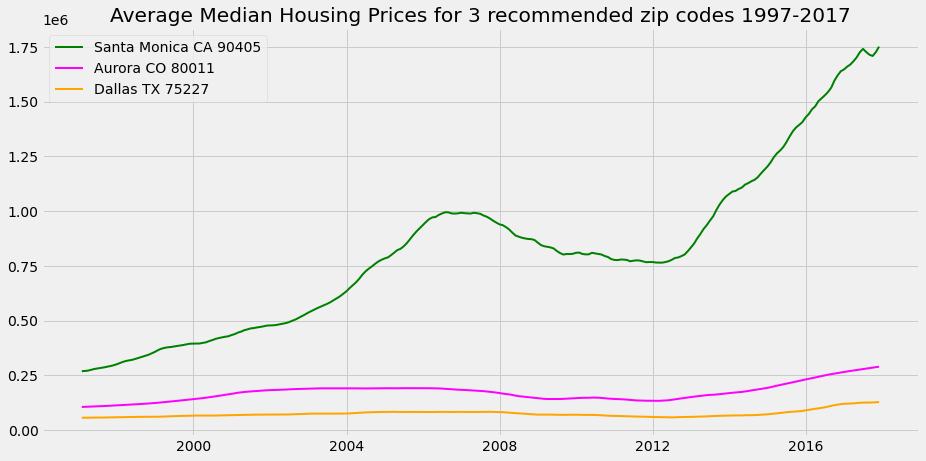

In [175]:
# graph the three zip codes

CA90405_2 = make_ts(top3_prices.iloc[0, :], 1811)
CO80011_2 = make_ts(top3_prices.iloc[1, :], 1078)
TX75227_2 = make_ts(top3_prices.iloc[2, :], 992)


plt.figure(figsize=(14,7))
plt.title("Average Median Housing Prices for 3 recommended zip codes 1997-2017")
plt.plot( 'Date', 'HouseValue', data=CA90405_2,  color='green', linewidth=2,  label="Santa Monica CA 90405")
plt.plot( 'Date', 'HouseValue', data=CO80011_2,  color='magenta', linewidth=2,  label="Aurora CO 80011")
plt.plot( 'Date', 'HouseValue', data=TX75227_2,  color='orange', linewidth=2,  label="Dallas TX 75227")
plt.legend()

In [0]:
def predict_and_plot(zip_ts, zip_title): 
    ts_3 = zip_ts.rename(index=str, columns={"HouseValue": "y", "Date": "ds"})
    #ts_3.head()
    ts_model = Prophet(interval_width=0.95)
    ts_model.fit(ts_3)
    future_ts = ts_model.make_future_dataframe(periods=12, freq='M')
    #future_ts.tail()
    forecastts = ts_model.predict(future_ts)
    #forecastts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    ts_model.plot(forecastts, uncertainty=True)
    plt.title(zip_title)
    plt.xlabel('Date')
    plt.ylabel('Median housing cost')

    plt.show()



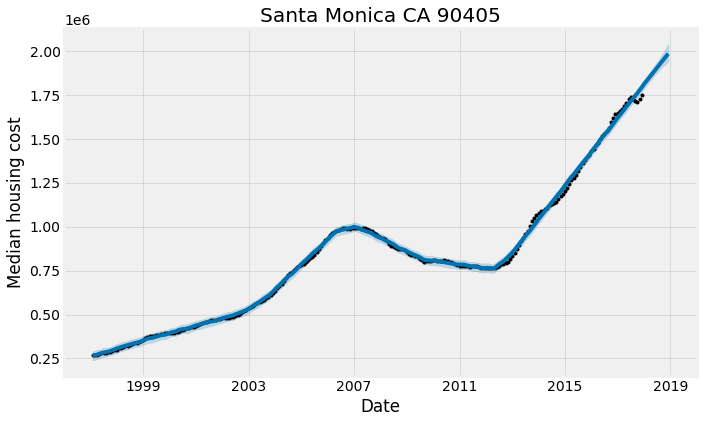

In [177]:

predict_and_plot(CA90405_2, "Santa Monica CA 90405")

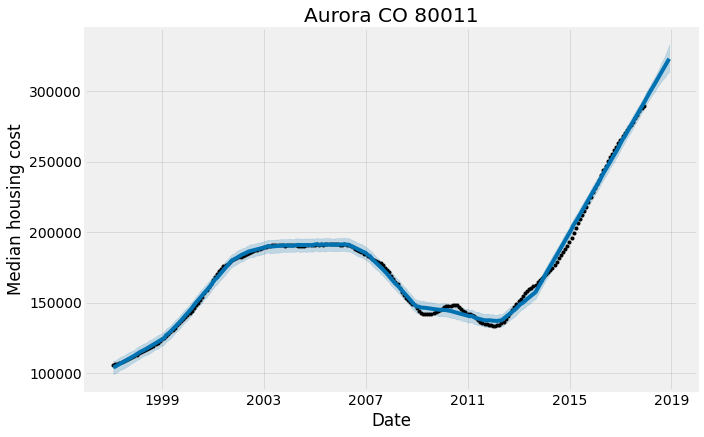

In [178]:
predict_and_plot(CO80011_2, "Aurora CO 80011")


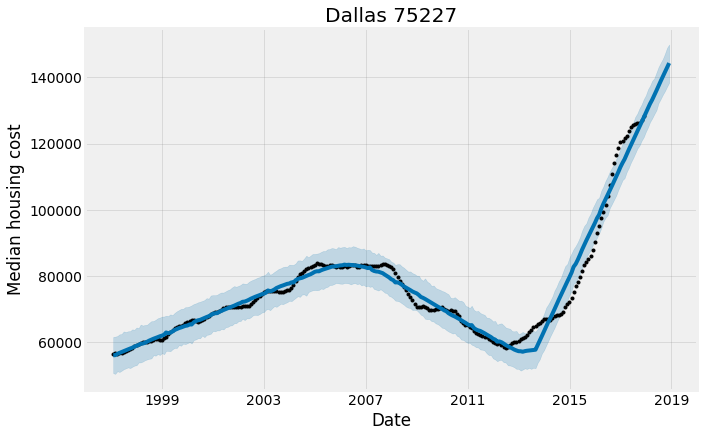

In [179]:
predict_and_plot(TX75227_2, 'Dallas 75227')

In [180]:
state_rec3 = top20ish.groupby('StateAbbr').count()[['Zipcode']].reset_index()
state_rec3

,StateAbbr,Zipcode
0,CA,2
1,CO,1
2,FL,2
3,LA,1
4,NY,7
5,TX,7


In [185]:

df = state_rec3

fig = go.Figure(data=go.Choropleth(
    locations=df['StateAbbr'], # Spatial coordinates
    z = df['Zipcode'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Number of zip codes in top 20",
))

fig.update_layout(
    title_text = 'States to invest in (model 3, emphasizing potential growth)',
    geo_scope='usa', # limit map to USA
)

fig.show()

# Recommendations

## Narrowing down the options
There were 33,000 zip codes in the initial dataset. To narrow down to a more reasonable number:

* I removed rows with too many blanks. Too many blanks would throw off the predictions. 
* Chose the top 2000 zip codes by population. Population is one of the main influences for growth.


## Prioritizing economic influences
There are an infinite number of possible economic indicators. I looked at housing price predicted growth percentage in one year, historical growth percentage over the last three years, employment rate, consumer spending (overall and for eating out), number of businesses, average payroll per business, and more. 

Although we are choosing zip codes for the S-REIT, zip codes are heavily influenced by the economy of the state they are in. A person might live, work, and shop in different zip codes, but most people do those things in one state. 

Taking all of these features, I then I used a random forest model to prioritze which of those features had the greatest influence:

* The strongest: population, 1 year growth, 3 year growth, number of businesses
* Also contributing: employment rate, consumer spending, average strength of the economy in the state


## Diversification mitigates risk
So we have 20 strong zipcodes, how do we choose between them?

First, I looked for the predictions that had a lower error rate (the prediction was more accurate). Then, I looked at the top three to see if they were different enough to each add something to the portfolio.

There are many ways to diversify: 

* State: If there were an earthquake in California, there might not be flooding in Texas at the same time.
* Prices: we could buy ten properties in Dallas for the price of one in Santa Monica, but the Santa Monica property would earn much more per year than a Dallas one.
* Other economic indicators: a variety of these mean that if something goes wrong with the economy it may not impact all properties equally. The whole country could be influenced by the same pandemic, but each local government could handle small business loans, unemployment, health care, etc differently. 



| Zipcode | City         | State | 2017 Price |Strengths  |
|---------|--------------|-------|------------:|-----------:|
| 90405   | Santa Monica | CA    | \$1,771,343 | Strong businesses, $200k increase in a year |
| 80011   | Aurora       | CO    | \$292,270 | High employment rate, high consumer spending |
| 75227   | Dallas       | TX    | \$130,211 |Bargain, high 3-year % increase  |


The S-REIT should consider expanding to more zip codes in the future. There are many strong real estate markets, and further diversificaiton would help. However, consider limiting the number of states we invest in, in order to reduce managerial/political overhead of running businesses in many locations. 


# References

[1] Real Estate Investment Trust (REIT) Definition. (2020). Investopedia. https://www.investopedia.com/terms/r/reit.asp

‌[2] Wikipedia Contributors. (2019, December 17). Karl E. Case. Wikipedia; Wikimedia Foundation. https://en.wikipedia.org/wiki/Karl_E._Case

‌[3] How to Assess the Values of Real Estate Investment Trusts - dummies. (2016). Dummies. https://www.dummies.com/personal-finance/investing/stocks-trading/how-to-assess-the-values-of-real-estate-investment-trusts/

‌

